In [2]:
# Sudoku OCR Solver - Complete Implementation
# This notebook contains all functions needed to solve Sudoku from images

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import os
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline plotting
%matplotlib inline

print("All imports loaded successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"Tesseract version: {pytesseract.get_tesseract_version()}")


All imports loaded successfully!
OpenCV version: 4.12.0
Tesseract version: 5.3.3.20231005


In [3]:
def read_sudoku_image(image_path: str, debug: bool = False) -> np.ndarray:
    """
    Read a Sudoku grid image from the specified path.
    
    Args:
        image_path (str): Path to the image file
        debug (bool): If True, displays the loaded image
        
    Returns:
        np.ndarray: The loaded image as a numpy array
        
    Raises:
        FileNotFoundError: If the image file doesn't exist
        ValueError: If the image cannot be loaded
    """
    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    # Read the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Could not load image from: {image_path}")
    
    # Convert BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if debug:
        print(f"Successfully loaded image: {image_path}")
        print(f"Image shape: {image.shape}")
        print(f"Image dtype: {image.dtype}")
        
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)
        plt.title(f"Loaded Sudoku Image: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()
    
    return image

def print_sudoku_board(board: np.ndarray) -> None:
    """Print a formatted Sudoku board."""
    print("=" * 25)
    for i, row in enumerate(board):
        if i % 3 == 0 and i != 0:
            print("-" * 25)
        row_str = " | ".join([str(x) if x != 0 else "." for x in row])
        print(f"{row_str}")
    print("=" * 25)


In [4]:
# Test cell for read_sudoku_image function
# print("Testing read_sudoku_image function...")

# # Test with the specified image
# image_path = "images/sudoku_grid1.png"
# try:
#     sudoku_image = read_sudoku_image(image_path, debug=True)
#     print("✓ Image loaded successfully!")
# except Exception as e:
#     print(f"✗ Error loading image: {e}")


In [5]:
# # default function settings reflect minimal processing (threshold only) that scored the highest
# def preprocess_sudoku_image(image: np.ndarray, debug: bool = False, 
#                           use_gaussian_blur: bool = False,
#                           use_adaptive_threshold: bool = True,
#                           use_morphological: bool = False,
#                           use_clahe: bool = False,
#                           use_median_blur: bool = False,
#                           use_inversion: bool = True, 
#                           blur_kernel_size: int = 5,
#                           threshold_block_size: int = 11,
#                           threshold_c: int = 2,
#                           morph_kernel_size: int = 2,
#                           clahe_clip_limit: float = 2.0,
#                           clahe_tile_size: int = 8,
#                           median_kernel_size: int = 3) -> np.ndarray:
#     """
#     Preprocess the Sudoku image to improve digit readability for OCR.
    
#     Args:
#         image (np.ndarray): Input Sudoku image
#         debug (bool): If True, displays intermediate processing steps
#         use_gaussian_blur (bool): Whether to apply Gaussian blur
#         use_adaptive_threshold (bool): Whether to apply adaptive thresholding
#         use_morphological (bool): Whether to apply morphological operations
#         use_clahe (bool): Whether to apply CLAHE enhancement
#         use_median_blur (bool): Whether to apply median blur
#         use_inversion (bool): Whether to apply inversion
#         blur_kernel_size (int): Gaussian blur kernel size
#         threshold_block_size (int): Adaptive threshold block size
#         threshold_c (int): Adaptive threshold C parameter
#         morph_kernel_size (int): Morphological operations kernel size
#         clahe_clip_limit (float): CLAHE clip limit
#         clahe_tile_size (int): CLAHE tile grid size
#         median_kernel_size (int): Median blur kernel size
        
#     Returns:
#         np.ndarray: Preprocessed image optimized for OCR
#     """
#     if debug:
#         print("Starting image preprocessing...")
#         print(f"Original image shape: {image.shape}")
#         print(f"Processing steps enabled:")
#         print(f"  - Gaussian Blur: {use_gaussian_blur}")
#         print(f"  - Adaptive Threshold: {use_adaptive_threshold}")
#         print(f"  - Morphological: {use_morphological}")
#         print(f"  - CLAHE: {use_clahe}")
#         print(f"  - Median Blur: {use_median_blur}")
    
#     # Step 1: Convert to grayscale (always required)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     current_image = gray.copy()
#     step_count = 1
    
#     if debug:
#         plt.figure(figsize=(15, 10))
#         plt.subplot(2, 3, 1)
#         plt.imshow(gray, cmap='gray')
#         plt.title("1. Grayscale")
#         plt.axis('off')
    
#     # Step 2: Apply Gaussian blur to reduce noise
#     if use_gaussian_blur:
#         current_image = cv2.GaussianBlur(current_image, (blur_kernel_size, blur_kernel_size), 0)
#         step_count += 1
        
#         if debug:
#             plt.subplot(2, 3, 2)
#             plt.imshow(current_image, cmap='gray')
#             plt.title(f"{step_count}. Gaussian Blur ({blur_kernel_size}x{blur_kernel_size})")
#             plt.axis('off')
    
#     # Step 3: Apply adaptive thresholding to handle varying lighting
#     if use_adaptive_threshold:
#         current_image = cv2.adaptiveThreshold(
#             current_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#             cv2.THRESH_BINARY, threshold_block_size, threshold_c
#         )
#         step_count += 1
        
#         if debug:
#             plt.subplot(2, 3, 3)
#             plt.imshow(current_image, cmap='gray')
#             plt.title(f"{step_count}. Adaptive Threshold ({threshold_block_size}, {threshold_c})")
#             plt.axis('off')
    
#     # Step 4: Morphological operations to clean up the image
#     if use_morphological:
#         kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
#         current_image = cv2.morphologyEx(current_image, cv2.MORPH_CLOSE, kernel)
#         current_image = cv2.morphologyEx(current_image, cv2.MORPH_OPEN, kernel)
#         step_count += 1
        
#         if debug:
#             plt.subplot(2, 3, 4)
#             plt.imshow(current_image, cmap='gray')
#             plt.title(f"{step_count}. Morphological ({morph_kernel_size}x{morph_kernel_size})")
#             plt.axis('off')
    
#     # Step 5: Enhance contrast for better digit visibility
#     if use_clahe:
#         clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=(clahe_tile_size, clahe_tile_size))
#         current_image = clahe.apply(current_image)
#         step_count += 1
        
#         if debug:
#             plt.subplot(2, 3, 5)
#             plt.imshow(current_image, cmap='gray')
#             plt.title(f"{step_count}. CLAHE ({clahe_clip_limit}, {clahe_tile_size}x{clahe_tile_size})")
#             plt.axis('off')
    
#     # Step 6: Final noise reduction
#     if use_median_blur:
#         current_image = cv2.medianBlur(current_image, median_kernel_size)
#         step_count += 1
        
#         if debug:
#             plt.subplot(2, 3, 6)
#             plt.imshow(current_image, cmap='gray')
#             plt.title(f"{step_count}. Median Blur ({median_kernel_size}x{median_kernel_size})")
#             plt.axis('off')
    
#     # Step 7: Invert image for better tesseract performance (white text on black background)
#     if use_inversion:
#         current_image = 255 - current_image
#         step_count += 1
    
#         if debug:
#             plt.subplot(2, 3, 6)
#             plt.imshow(current_image, cmap='gray')
#             plt.title(f"{step_count}. Inverted (White on Black)")
#             plt.axis('off')
    
#     if debug:
#         plt.tight_layout()
#         plt.show()
        
#         print("Preprocessing completed!")
#         print(f"Final image shape: {current_image.shape}")
#         print(f"Final image dtype: {current_image.dtype}")
    
#     return current_image


In [6]:
def preprocess_sudoku_image(image: np.ndarray, debug: bool = False, 
                          detect_grid: bool = True,
                          threshold_block_size: int = 11,
                          threshold_c: int = 2) -> np.ndarray:
    """
    Preprocess the Sudoku image with integrated grid detection, thresholding, and inversion.
    
    Args:
        image (np.ndarray): Input Sudoku image
        debug (bool): If True, displays intermediate processing steps
        detect_grid (bool): If True, detects and crops the Sudoku grid
        threshold_block_size (int): Adaptive threshold block size
        threshold_c (int): Adaptive threshold C parameter
        
    Returns:
        np.ndarray: Preprocessed image optimized for OCR
    """
    if debug:
        print("Starting Sudoku image preprocessing...")
        print(f"Original image shape: {image.shape}")
        print(f"Grid detection: {detect_grid}")
        plt.figure(figsize=(20, 5))
    
    current_image = image.copy()
    step_count = 0
    
    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
    step_count += 1
    
    if debug:
        plt.subplot(1, 6, step_count)
        plt.imshow(gray, cmap='gray')
        plt.title("1. Grayscale")
        plt.axis('off')
    
    # Step 2: Grid detection and perspective correction (if enabled)
    if detect_grid:
        step_count += 1
        
        # Apply Gaussian blur for contour detection
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Apply adaptive thresholding for contour detection
        thresh_for_contours = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                   cv2.THRESH_BINARY, 11, 2)
        
        # Invert for contour detection (grid lines should be white)
        thresh_for_contours = 255 - thresh_for_contours
        
        if debug:
            plt.subplot(1, 6, step_count)
            plt.imshow(thresh_for_contours, cmap='gray')
            plt.title("2. Thresh for Contours")
            plt.axis('off')
        
        # Find contours
        contours, _ = cv2.findContours(thresh_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        grid_detected = False
        if contours:
            # Find the largest contour (should be the Sudoku grid)
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Approximate the contour to a polygon
            epsilon = 0.02 * cv2.arcLength(largest_contour, True)
            approx = cv2.approxPolyDP(largest_contour, epsilon, True)
            
            # If we don't get exactly 4 corners, try different epsilon values
            if len(approx) != 4:
                for epsilon_factor in [0.01, 0.03, 0.04, 0.05]:
                    epsilon = epsilon_factor * cv2.arcLength(largest_contour, True)
                    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
                    if len(approx) == 4:
                        break
            
            # If we found 4 corners, apply perspective correction
            if len(approx) == 4:
                step_count += 1
                
                # Order the corners: top-left, top-right, bottom-right, bottom-left
                corners = approx.reshape(4, 2).astype(np.float32)
                
                # Calculate the centroid
                centroid = np.mean(corners, axis=0)
                
                # Sort corners based on their position relative to centroid
                def classify_corner(point, center):
                    if point[0] < center[0] and point[1] < center[1]:
                        return 0  # top-left
                    elif point[0] > center[0] and point[1] < center[1]:
                        return 1  # top-right
                    elif point[0] > center[0] and point[1] > center[1]:
                        return 2  # bottom-right
                    else:
                        return 3  # bottom-left
                
                ordered_corners = np.zeros((4, 2), dtype=np.float32)
                for corner in corners:
                    idx = classify_corner(corner, centroid)
                    ordered_corners[idx] = corner
                
                # Calculate the size of the output square
                width1 = np.linalg.norm(ordered_corners[1] - ordered_corners[0])
                width2 = np.linalg.norm(ordered_corners[2] - ordered_corners[3])
                height1 = np.linalg.norm(ordered_corners[3] - ordered_corners[0])
                height2 = np.linalg.norm(ordered_corners[2] - ordered_corners[1])
                
                max_dim = int(max(width1, width2, height1, height2))
                
                # Define destination points for perspective transformation
                dst_corners = np.array([
                    [0, 0],
                    [max_dim - 1, 0],
                    [max_dim - 1, max_dim - 1],
                    [0, max_dim - 1]
                ], dtype=np.float32)
                
                # Calculate perspective transformation matrix
                transform_matrix = cv2.getPerspectiveTransform(ordered_corners, dst_corners)
                
                # Apply perspective transformation to the original image
                current_image = cv2.warpPerspective(current_image, transform_matrix, (max_dim, max_dim))
                
                # Update grayscale image after perspective correction
                gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
                grid_detected = True
                
                if debug:
                    # Show corner detection
                    contour_img = image.copy()
                    cv2.drawContours(contour_img, [largest_contour], -1, (0, 255, 0), 3)
                    cv2.drawContours(contour_img, [approx], -1, (255, 0, 0), 5)
                    for i, point in enumerate(approx):
                        cv2.circle(contour_img, tuple(point[0]), 10, (0, 0, 255), -1)
                    
                    plt.subplot(1, 6, step_count)
                    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
                    plt.title(f"3. Grid Detected")
                    plt.axis('off')
        
        if debug and not grid_detected:
            step_count += 1
            plt.subplot(1, 6, step_count)
            plt.imshow(gray, cmap='gray')
            plt.title("3. Grid Not Detected")
            plt.axis('off')
            print("Warning: Could not detect 4 corners, using original image")
    
    # Step 3/4: Apply adaptive thresholding to final grayscale image
    step_count += 1
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, threshold_block_size, threshold_c
    )
    
    if debug:
        plt.subplot(1, 6, step_count)
        plt.imshow(thresh, cmap='gray')
        plt.title(f"{step_count}. Adaptive Threshold")
        plt.axis('off')
    
    # Step 4/5: Invert image for better tesseract performance
    step_count += 1
    inverted = 255 - thresh
    
    if debug:
        plt.subplot(1, 6, step_count)
        plt.imshow(inverted, cmap='gray')
        plt.title(f"{step_count}. Final (Inverted)")
        plt.axis('off')
        
        # Show before/after comparison
        step_count += 1
        if step_count <= 6:
            plt.subplot(1, 6, step_count)
            original_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            plt.imshow(original_gray, cmap='gray')
            plt.title("Original for Comparison")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("Preprocessing completed!")
        print(f"Final image shape: {inverted.shape}")
        print(f"Grid detection successful: {grid_detected if detect_grid else 'N/A'}")
    
    return inverted

Testing preprocess_sudoku_image function...
Starting Sudoku image preprocessing...
Original image shape: (552, 555, 3)
Grid detection: True


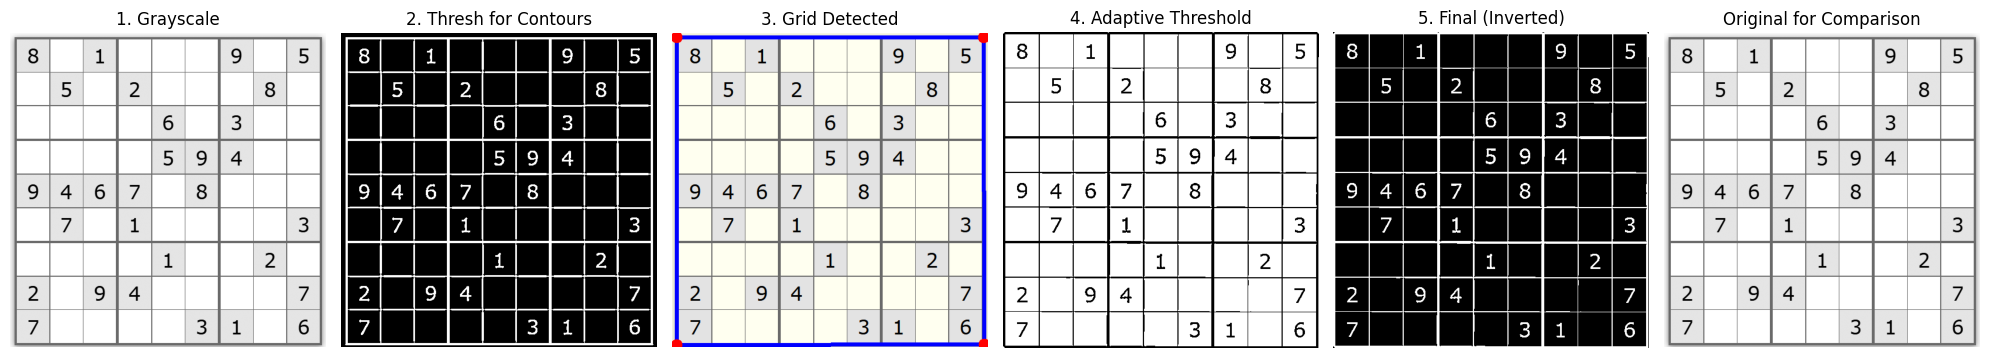

Preprocessing completed!
Final image shape: (540, 540)
Grid detection successful: True
✓ Image preprocessing completed successfully!


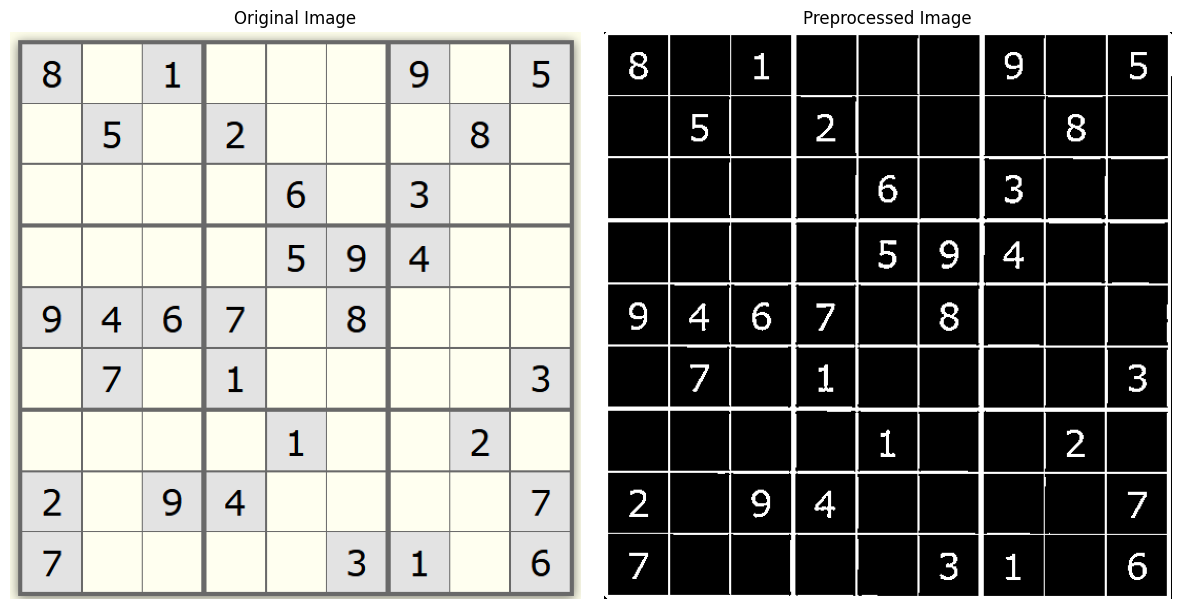

In [7]:
# Test cell for preprocess_sudoku_image function
print("Testing preprocess_sudoku_image function...")

# Load the image first
image_path = "images/sudoku_grid2.png"
try:
    original_image = read_sudoku_image(image_path, debug=False)
    
    # Apply preprocessing
    processed_image = preprocess_sudoku_image(original_image, debug=True)
    
    print("✓ Image preprocessing completed successfully!")
    
    # Show comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_image, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"✗ Error in preprocessing: {e}")


In [8]:
def extract_sudoku_grid(processed_image: np.ndarray, debug: bool = False) -> np.ndarray:
    """
    Extract the Sudoku grid from the processed image using simple OCR on each cell.
    
    Args:
        processed_image (np.ndarray): Preprocessed Sudoku image (should be inverted)
        debug (bool): If True, displays the grid extraction and OCR results
        
    Returns:
        np.ndarray: 9x9 array representing the Sudoku board (0 for empty cells)
    """
    if debug:
        print("Starting simple Sudoku grid extraction...")
    
    # Initialize the 9x9 Sudoku board
    sudoku_board = np.zeros((9, 9), dtype=int)
    
    # Calculate cell dimensions
    height, width = processed_image.shape
    cell_height = height // 9
    cell_width = width // 9
    
    if debug:
        print(f"Image dimensions: {width}x{height}")
        print(f"Cell dimensions: {cell_width}x{cell_height}")
        
        # Create a figure to show all cells
        fig, axes = plt.subplots(9, 9, figsize=(12, 12))
        fig.suptitle("Individual Sudoku Cells with Simple OCR Results", fontsize=16)
    
    def has_content_pixels(cell_image: np.ndarray, threshold: int = 10) -> bool:
        """
        Check if a cell contains any non-background pixels that might indicate a digit.
        
        Args:
            cell_image (np.ndarray): Cell image to analyze
            threshold (int): Minimum pixel value difference to consider as content
            
        Returns:
            bool: True if cell appears to contain content, False if truly empty
        """
        # For inverted images, background is black (0) and content is white (255)
        # Check if there are any pixels significantly different from background
        non_background_pixels = np.sum(cell_image > threshold)
        total_pixels = cell_image.size
        
        # If more than 2% of pixels are non-background, consider it as having content
        content_ratio = non_background_pixels / total_pixels
        return content_ratio > 0.02
    
    # Simple Tesseract configuration for single digits
    tesseract_config = '--oem 3 --psm 10 -c tessedit_char_whitelist=123456789'
    
    # Process each cell
    for row in range(9):
        for col in range(9):
            # if debug:
            #     print(f"Processing cell ({row+1}, {col+1})...")
            
            # Calculate cell boundaries
            y1 = row * cell_height
            y2 = (row + 1) * cell_height
            x1 = col * cell_width
            x2 = (col + 1) * cell_width
            
            # Extract cell image
            cell = processed_image[y1:y2, x1:x2]
            
            # First check if the cell has any content pixels
            has_content = has_content_pixels(cell)
            
            if not has_content:
                # Cell appears to be truly empty (just background and borders)
                if debug:
                    print(f"  Cell appears empty (no content pixels detected)")
                continue
            
            # Add padding to the cell
            padding = 10
            cell_padded = cv2.copyMakeBorder(
                cell, padding, padding, padding, padding, 
                cv2.BORDER_CONSTANT, value=0  # Black padding since image is inverted
            )
            
            # Resize to a standard size for better OCR
            cell_resized = cv2.resize(cell_padded, (100, 100), interpolation=cv2.INTER_CUBIC)
            
            # Apply basic OCR
            try:
                text = pytesseract.image_to_string(cell_resized, config=tesseract_config).strip()
                
                # Extract digit from the text
                digit = None
                for char in text:
                    if char.isdigit() and '1' <= char <= '9':
                        digit = int(char)
                        break
                
                if digit is not None:
                    sudoku_board[row, col] = digit
                    if debug:
                        print(f"  Found digit: {digit}")
                else:
                    if debug:
                        print(f"  Content detected but no digit found (text: '{text}')")
                        
            except Exception as e:
                if debug:
                    print(f"  OCR error: {e}")
            
            if debug:
                # Display the cell
                axes[row, col].imshow(cell_resized, cmap='gray')
                title = f"R{row+1}C{col+1}: {sudoku_board[row, col] if sudoku_board[row, col] != 0 else 'Empty'}"
                axes[row, col].set_title(title, fontsize=8)
                axes[row, col].axis('off')
    
    if debug:
        plt.tight_layout()
        plt.show()
        
        print("\nExtracted Sudoku Board:")
        print("=" * 25)
        for i, row in enumerate(sudoku_board):
            if i % 3 == 0 and i != 0:
                print("-" * 25)
            row_str = " | ".join([str(x) if x != 0 else "." for x in row])
            print(f"{row_str}")
        print("=" * 25)
        
        # Count filled cells
        filled_cells = np.count_nonzero(sudoku_board)
        print(f"\nFilled cells: {filled_cells}/81")
        print(f"Empty cells: {81 - filled_cells}/81")
    
    return sudoku_board


In [9]:
from scipy import ndimage
from skimage import morphology, measure
import easyocr

In [10]:
def extract_sudoku_grid(processed_image: np.ndarray, debug: bool = False) -> np.ndarray:
    """
    Sudoku grid extraction with improved OCR accuracy
    
    Args:
        processed_image (np.ndarray): Preprocessed Sudoku image (should be inverted)
        debug (bool): If True, displays the grid extraction and OCR results
        
    Returns:
        np.ndarray: 9x9 array representing the Sudoku board (0 for empty cells)
    """
    if debug:
        print("Starting Sudoku grid extraction...")
    
    # Initialize the 9x9 Sudoku board
    sudoku_board = np.zeros((9, 9), dtype=int)
    
    # Calculate cell dimensions
    height, width = processed_image.shape
    cell_height = height // 9
    cell_width = width // 9
    
    if debug:
        print(f"Image dimensions: {width}x{height}")
        print(f"Cell dimensions: {cell_width}x{cell_height}")
        
        # Create a figure to show all cells
        fig, axes = plt.subplots(9, 9, figsize=(12, 12))
        fig.suptitle("Sudoku Cells with Two-Stage OCR", fontsize=16)
    
    # Initialize EasyOCR reader (lazy initialization)
    easyocr_reader = None
    
    def has_content_pixels(cell_image: np.ndarray) -> bool:
        """
        Quick check for white pixels that could be a digit (not border pixels).
        
        Args:
            cell_image (np.ndarray): Cell image to analyze
            
        Returns:
            bool: True if cell appears to contain digit content
        """
        # Remove border pixels to avoid detecting grid lines as content
        border_margin = 3
        h, w = cell_image.shape
        if h <= 2 * border_margin or w <= 2 * border_margin:
            return False
            
        inner_region = cell_image[border_margin:-border_margin, border_margin:-border_margin]
        
        # Count white pixels (in inverted image, digits are white)
        white_pixels = np.sum(inner_region > 100)  # Threshold for "white" pixels
        total_inner_pixels = inner_region.size
        
        # If more than 3% of inner pixels are white, consider it has content
        content_ratio = white_pixels / total_inner_pixels
        return content_ratio > 0.03
    
    def additional_content_check(cell_image: np.ndarray) -> bool:
        """
        More thorough content check using connected components.
        
        Args:
            cell_image (np.ndarray): Cell image to analyze
            
        Returns:
            bool: True if cell definitely has digit content
        """
        # Apply threshold to get binary image
        _, binary = cv2.threshold(cell_image, 100, 255, cv2.THRESH_BINARY)
        
        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
        
        # Look for components that could be digits
        for i in range(1, num_labels):  # Skip background (label 0)
            area = stats[i, cv2.CC_STAT_AREA]
            x, y = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
            w, h = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            
            # Check if component looks like it could be a digit
            if (area > 50 and  # Minimum area for a digit
                w > 5 and h > 5 and  # Minimum dimensions
                x > 2 and y > 2 and  # Not touching edges
                x + w < cell_image.shape[1] - 2 and 
                y + h < cell_image.shape[0] - 2):
                return True
        
        return False
    

    def preprocess_cell_for_ocr(cell_image: np.ndarray) -> np.ndarray:
        """
        Preprocess cell for optimal OCR.
        
        Args:
            cell_image (np.ndarray): Raw cell image
            
        Returns:
            np.ndarray: Preprocessed cell image
        """
        # Add padding
        padding = 15
        padded = cv2.copyMakeBorder(
            cell_image, padding, padding, padding, padding, 
            cv2.BORDER_CONSTANT, value=0
        )
        
        # Resize to standard size
        resized = cv2.resize(padded, (100, 100), interpolation=cv2.INTER_CUBIC)
        
        # Apply slight blur to smooth edges
        blurred = cv2.GaussianBlur(resized, (3, 3), 0)
        
        return blurred
    

    def basic_tesseract_ocr(cell_image: np.ndarray) -> tuple:
        """
        Perform basic Tesseract OCR on cell.
        
        Args:
            cell_image (np.ndarray): Preprocessed cell image
            
        Returns:
            tuple: (digit, confidence) where digit is int or None
        """
        try:
            # Basic Tesseract config for single digits
            config = '--oem 3 --psm 10 -c tessedit_char_whitelist=123456789'
            
            # Get confidence data
            data = pytesseract.image_to_data(cell_image, config=config, output_type=pytesseract.Output.DICT)
            
            # Extract text
            text = pytesseract.image_to_string(cell_image, config=config).strip()
            
            # Find digit in text
            digit = None
            for char in text:
                if char.isdigit() and '1' <= char <= '9':
                    digit = int(char)
                    break
            
            # Calculate average confidence
            confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
            avg_confidence = np.mean(confidences) if confidences else 0
            
            return digit, avg_confidence
            
        except Exception as e:
            if debug:
                print(f"    Tesseract OCR error: {e}")
            return None, 0

    def easyocr_fallback(cell_image: np.ndarray) -> tuple:
        """
        Fallback OCR using EasyOCR for difficult cases.
        
        Args:
            cell_image (np.ndarray): Preprocessed cell image
            
        Returns:
            tuple: (digit, confidence) where digit is int or None
        """
        nonlocal easyocr_reader
        
        try:
            # Initialize EasyOCR reader if not already done
            if easyocr_reader is None:
                import easyocr
                easyocr_reader = easyocr.Reader(['en'], gpu=False, verbose=False)
            
            # Run EasyOCR
            results = easyocr_reader.readtext(cell_image, allowlist='123456789', width_ths=0.1)
            
            # Extract digit with highest confidence
            best_digit = None
            best_confidence = 0
            
            for (bbox, text, confidence) in results:
                text = text.strip()
                
                # Only accept EXACTLY one digit between 1-9
                if (len(text) == 1 and 
                    text.isdigit() and 
                    '1' <= text <= '9'):
                    confidence_percent = confidence * 100  # Convert to 0-100 scale
                    if confidence_percent > best_confidence:
                        best_digit = int(text)
                        best_confidence = confidence_percent
                        if debug:
                            print(f"    EasyOCR found single digit: '{text}' with confidence {confidence_percent:.1f}")
                elif len(text) == 2 and text.isdigit():
                    # Two digit result - likely a false positive
                    # Check if it's a repeated digit (like "77") or starts with "1" (like "17")
                    if text[0] == text[1]:
                        # Repeated digit like "77" -> use the digit
                        digit = int(text[0])
                        if '1' <= str(digit) <= '9':
                            confidence_percent = confidence * 100 * 0.8  # Reduce confidence slightly
                            if confidence_percent > best_confidence:
                                best_digit = digit
                                best_confidence = confidence_percent
                                if debug:
                                    print(f"    EasyOCR extracted {digit} from repeated '{text}'")
                    elif text.startswith('1') and len(text) == 2:
                        # Cases like "17" where "7" is likely the real digit
                        digit = int(text[1])
                        if '1' <= str(digit) <= '9':
                            confidence_percent = confidence * 100 * 0.7  # Reduce confidence more
                            if confidence_percent > best_confidence:
                                best_digit = digit
                                best_confidence = confidence_percent
                                if debug:
                                    print(f"    EasyOCR extracted {digit} from '1{digit}' pattern")
                elif debug and text:
                    # Log rejected results for debugging
                    print(f"    EasyOCR rejected result: '{text}' (not single digit 1-9)")
            
            
            return best_digit, best_confidence
            
        except ImportError:
            if debug:
                print("    EasyOCR not available")
            return None, 0
        except Exception as e:
            if debug:
                print(f"    EasyOCR error: {e}")
            return None, 0
    
###### Process each cell
    for row in range(9):
        for col in range(9):
            if debug:
                print(f"Processing cell ({row+1}, {col+1})...")
            
            # Calculate cell boundaries with margin to avoid grid lines
            margin = 3
            y1 = row * cell_height + margin
            y2 = (row + 1) * cell_height - margin
            x1 = col * cell_width + margin
            x2 = (col + 1) * cell_width - margin
            
            # Extract cell image
            cell = processed_image[y1:y2, x1:x2]
            
            # Step 1: Quick content check
            has_content = has_content_pixels(cell)
            
            if debug:
                print(f"  Initial content check: {has_content}")
            
            if not has_content:
                # Step 2: Additional content check before declaring empty
                has_content = additional_content_check(cell)
                if debug:
                    print(f"  Additional content check: {has_content}")
            
            if not has_content:
                # Cell is truly empty
                sudoku_board[row, col] = 0
                if debug:
                    print("  Cell marked as empty")
            else:
                # Cell has content - perform OCR
                if debug:
                    print("  Cell has content, performing OCR...")
                
                # Preprocess cell for OCR
                processed_cell = preprocess_cell_for_ocr(cell)
                
                # Step 3: Basic Tesseract OCR
                digit_tesseract, confidence = basic_tesseract_ocr(processed_cell)
                
                if debug:
                    print(f"  Tesseract result: digit={digit_tesseract}, confidence={confidence:.1f}")


                
                # Check if Tesseract result is confident enough
                if digit_tesseract is not None and confidence > 60:
                    # Accept Tesseract result
                    sudoku_board[row, col] = digit_tesseract
                    if debug:
                        print(f"  Accepted Tesseract result: {digit_tesseract}")
                else:
                    # Step 4: Fallback to EasyOCR
                    if debug:
                        print("  Tesseract confidence low, trying EasyOCR...")
                    
                    digit_easy, confidence_easy = easyocr_fallback(processed_cell)
                    
                    if debug:
                        print(f"  EasyOCR result: digit={digit_easy}, confidence={confidence_easy:.1f}")
                    
                    # Check if EasyOCR result is confident enough
                    if digit_easy is not None and confidence_easy > 40:
                        # EasyOCR found a valid single digit
                        sudoku_board[row, col] = digit_easy
                        if debug:
                            print(f"  Accepted EasyOCR result: {digit_easy}")
                    elif digit_tesseract is not None:
                        # EasyOCR failed but Tesseract found something - use Tesseract despite low confidence
                        sudoku_board[row, col] = digit_tesseract
                        if debug:
                            print(f"  EasyOCR failed, falling back to Tesseract result: {digit_tesseract}")
            
            if debug:
                # Display the cell with result
                axes[row, col].imshow(cell, cmap='gray')
                result_val = sudoku_board[row, col]
                title = f"R{row+1}C{col+1}: {result_val if result_val != 0 else 'Empty'}"
                axes[row, col].set_title(title, fontsize=8)
                axes[row, col].axis('off')
    if debug:
        plt.tight_layout()
        plt.show()
        
        print("\nExtracted Sudoku Board:")
        print("=" * 25)
        for i, row in enumerate(sudoku_board):
            if i % 3 == 0 and i != 0:
                print("-" * 25)
            row_str = " | ".join([str(x) if x != 0 else "." for x in row])
            print(f"{row_str}")
        print("=" * 25)
        
        # Count filled cells
        filled_cells = np.count_nonzero(sudoku_board)
        print(f"\nFilled cells: {filled_cells}/81")
        print(f"Empty cells: {81 - filled_cells}/81")
        
    return sudoku_board


In [11]:
# # Preprocessing Optimization Test - Compare different preprocessing combinations
# print("="*70)
# print("PREPROCESSING OPTIMIZATION TEST")
# print("="*70)

# def calculate_accuracy(extracted_board: np.ndarray, master_key: np.ndarray) -> float:
#     """
#     Calculate the accuracy of extracted board compared to master key.
    
#     Args:
#         extracted_board (np.ndarray): Board extracted by OCR
#         master_key (np.ndarray): Correct reference board
        
#     Returns:
#         float: Accuracy percentage (0-100)
#     """
#     if extracted_board.shape != master_key.shape:
#         return 0.0
    
#     # Count correct matches (only for non-zero cells in master key)
#     correct = 0
#     total = 0
    
#     for i in range(9):
#         for j in range(9):
#             if master_key[i, j] != 0:  # Only check cells that should have digits
#                 total += 1
#                 if extracted_board[i, j] == master_key[i, j]:
#                     correct += 1
    
#     return (correct / total * 100) if total > 0 else 0.0

# def test_preprocessing_combination(image: np.ndarray, master_key: np.ndarray, 
#                                  combination_name: str, **preprocessing_params) -> dict:
#     """
#     Test a specific preprocessing combination and return results.
    
#     Args:
#         image (np.ndarray): Original image
#         master_key (np.ndarray): Correct reference board
#         combination_name (str): Name for this combination
#         **preprocessing_params: Parameters for preprocessing function
        
#     Returns:
#         dict: Results including accuracy, extracted board, and processing time
#     """
#     import time
    
#     start_time = time.time()
    
#     try:
#         # Apply preprocessing
#         processed_image = preprocess_sudoku_image(image, debug=False, **preprocessing_params)
        
#         # Extract grid using OCR
#         extracted_board = extract_sudoku_grid(processed_image, debug=False)
        
#         # Calculate accuracy
#         accuracy = calculate_accuracy(extracted_board, master_key)
        
#         processing_time = time.time() - start_time
        
#         return {
#             'name': combination_name,
#             'accuracy': accuracy,
#             'extracted_board': extracted_board,
#             'processing_time': processing_time,
#             'params': preprocessing_params,
#             'success': True
#         }
        
#     except Exception as e:
#         processing_time = time.time() - start_time
#         return {
#             'name': combination_name,
#             'accuracy': 0.0,
#             'extracted_board': None,
#             'processing_time': processing_time,
#             'params': preprocessing_params,
#             'success': False,
#             'error': str(e)
#         }

# # Define the master key for sudoku_grid1.png
# master_key = np.array([
#     [0, 0, 8, 3, 0, 0, 1, 2, 0],
#     [0, 0, 0, 6, 8, 0, 0, 0, 7],
#     [0, 6, 7, 0, 5, 0, 0, 0, 0],
#     [5, 0, 0, 2, 0, 6, 0, 4, 0],
#     [3, 0, 9, 8, 0, 0, 0, 7, 0],
#     [0, 0, 0, 0, 4, 0, 8, 0, 1],
#     [0, 0, 5, 0, 0, 0, 9, 0, 3],
#     [2, 0, 0, 0, 0, 9, 0, 8, 0],
#     [0, 0, 4, 7, 0, 1, 0, 0, 0]
# ])

# # Load the test image
# image_path = "images/sudoku_grid1.png"
# test_image = read_sudoku_image(image_path, debug=False)

# # Define different preprocessing combinations to test
# preprocessing_combinations = [
#     {
#         'name': 'All Steps (Default)',
#         'params': {
#             'use_gaussian_blur': True,
#             'use_adaptive_threshold': True,
#             'use_morphological': True,
#             'use_clahe': True,
#             'use_median_blur': True
#         }
#     },
#     {
#         'name': 'No Gaussian Blur',
#         'params': {
#             'use_gaussian_blur': False,
#             'use_adaptive_threshold': True,
#             'use_morphological': True,
#             'use_clahe': True,
#             'use_median_blur': True
#         }
#     },
#     {
#         'name': 'No Adaptive Threshold',
#         'params': {
#             'use_gaussian_blur': True,
#             'use_adaptive_threshold': False,
#             'use_morphological': True,
#             'use_clahe': True,
#             'use_median_blur': True
#         }
#     },
#     {
#         'name': 'No Morphological',
#         'params': {
#             'use_gaussian_blur': True,
#             'use_adaptive_threshold': True,
#             'use_morphological': False,
#             'use_clahe': True,
#             'use_median_blur': True
#         }
#     },
#     {
#         'name': 'No CLAHE',
#         'params': {
#             'use_gaussian_blur': True,
#             'use_adaptive_threshold': True,
#             'use_morphological': True,
#             'use_clahe': False,
#             'use_median_blur': True
#         }
#     },
#     {
#         'name': 'No Median Blur',
#         'params': {
#             'use_gaussian_blur': True,
#             'use_adaptive_threshold': True,
#             'use_morphological': True,
#             'use_clahe': True,
#             'use_median_blur': False
#         }
#     },
#     {
#         'name': 'Minimal (Only Threshold)',
#         'params': {
#             'use_gaussian_blur': False,
#             'use_adaptive_threshold': True,
#             'use_morphological': False,
#             'use_clahe': False,
#             'use_median_blur': False
#         }
#     },
#     {
#         'name': 'Enhanced Blur (7x7)',
#         'params': {
#             'use_gaussian_blur': True,
#             'blur_kernel_size': 7,
#             'use_adaptive_threshold': True,
#             'use_morphological': True,
#             'use_clahe': True,
#             'use_median_blur': True
#         }
#     },
#     {
#         'name': 'Enhanced Threshold (15, 3)',
#         'params': {
#             'use_gaussian_blur': True,
#             'use_adaptive_threshold': True,
#             'threshold_block_size': 15,
#             'threshold_c': 3,
#             'use_morphological': True,
#             'use_clahe': True,
#             'use_median_blur': True
#         }
#     },
#     {
#         'name': 'Enhanced CLAHE (3.0, 4x4)',
#         'params': {
#             'use_gaussian_blur': True,
#             'use_adaptive_threshold': True,
#             'use_morphological': True,
#             'use_clahe': True,
#             'clahe_clip_limit': 3.0,
#             'clahe_tile_size': 4,
#             'use_median_blur': True
#         }
#     }
# ]

# print(f"Testing {len(preprocessing_combinations)} different preprocessing combinations...")
# print("This may take a few minutes...")

# # Test all combinations
# results = []
# for i, combo in enumerate(preprocessing_combinations):
#     print(f"Testing {i+1}/{len(preprocessing_combinations)}: {combo['name']}")
#     result = test_preprocessing_combination(test_image, master_key, combo['name'], **combo['params'])
#     results.append(result)
    
#     if result['success']:
#         print(f"  Accuracy: {result['accuracy']:.1f}%")
#         print(f"  Processing time: {result['processing_time']:.2f}s")
#     else:
#         print(f"  Failed: {result.get('error', 'Unknown error')}")

# # Sort results by accuracy (descending)
# results.sort(key=lambda x: x['accuracy'], reverse=True)

# print(f"\n" + "="*70)
# print("PREPROCESSING OPTIMIZATION RESULTS")
# print("="*70)

# # Display results table
# print(f"{'Rank':<4} {'Combination':<25} {'Accuracy':<10} {'Time (s)':<10} {'Status'}")
# print("-" * 70)

# for i, result in enumerate(results):
#     rank = i + 1
#     name = result['name'][:24]  # Truncate long names
#     accuracy = f"{result['accuracy']:.1f}%" if result['success'] else "0.0%"
#     time_str = f"{result['processing_time']:.2f}"
#     status = "✓ Success" if result['success'] else "✗ Failed"
    
#     print(f"{rank:<4} {name:<25} {accuracy:<10} {time_str:<10} {status}")

# # Find best combination
# best_result = results[0] if results else None

# if best_result and best_result['success']:
#     print(f"🏆 BEST COMBINATION: {best_result['name']}")
#     print(f"   Accuracy: {best_result['accuracy']:.1f}%")
#     print(f"   Processing time: {best_result['processing_time']:.2f}s")
#     print(f"   Parameters: {best_result['params']}")
    
#     # Show comparison of best result vs master key
#     print("Best result extracted board:")
#     print_sudoku_board(best_result['extracted_board'])
    
#     print("Master key (reference):")
#     print_sudoku_board(master_key)
    
#     # Visual comparison
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
#     # Original image
#     axes[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
#     axes[0].set_title('Original Image')
#     axes[0].axis('off')
    
#     # Best extracted board
#     im1 = axes[1].imshow(best_result['extracted_board'], cmap='viridis')
#     axes[1].set_title(f'Best Extracted Board\\n({best_result["name"]})')
#     axes[1].set_xlabel('Column')
#     axes[1].set_ylabel('Row')
#     plt.colorbar(im1, ax=axes[1])
    
#     # Master key
#     im2 = axes[2].imshow(master_key, cmap='viridis')
#     axes[2].set_title('Master Key (Reference)')
#     axes[2].set_xlabel('Column')
#     axes[2].set_ylabel('Row')
#     plt.colorbar(im2, ax=axes[2])
    
#     plt.tight_layout()
#     plt.show()
    
# else:
#     print("❌ No successful preprocessing combinations found!")
#     print("This might indicate issues with:")
#     print("- The master key (please verify it's correct)")
#     print("- OCR configuration")
#     print("- Image quality")

# print("\n" + "="*70)
# print("OPTIMIZATION TEST COMPLETED")
# print("="*70)


Testing extract_sudoku_grid function...
Testing enhanced OCR extraction with confidence-based reprocessing...
This may take longer due to multiple OCR attempts per cell...
Starting Sudoku grid extraction...
Image dimensions: 539x539
Cell dimensions: 59x59
Processing cell (1, 1)...
  Initial content check: False
  Additional content check: False
  Cell marked as empty
Processing cell (1, 2)...
  Initial content check: False
  Additional content check: False
  Cell marked as empty
Processing cell (1, 3)...
  Initial content check: True
  Cell has content, performing OCR...
  Tesseract result: digit=8, confidence=74.0
  Accepted Tesseract result: 8
Processing cell (1, 4)...
  Initial content check: True
  Cell has content, performing OCR...
  Tesseract result: digit=3, confidence=0.0
  Tesseract confidence low, trying EasyOCR...
    EasyOCR found single digit: '3' with confidence 100.0
  EasyOCR result: digit=3, confidence=100.0
  Accepted EasyOCR result: 3
Processing cell (1, 5)...
  Ini

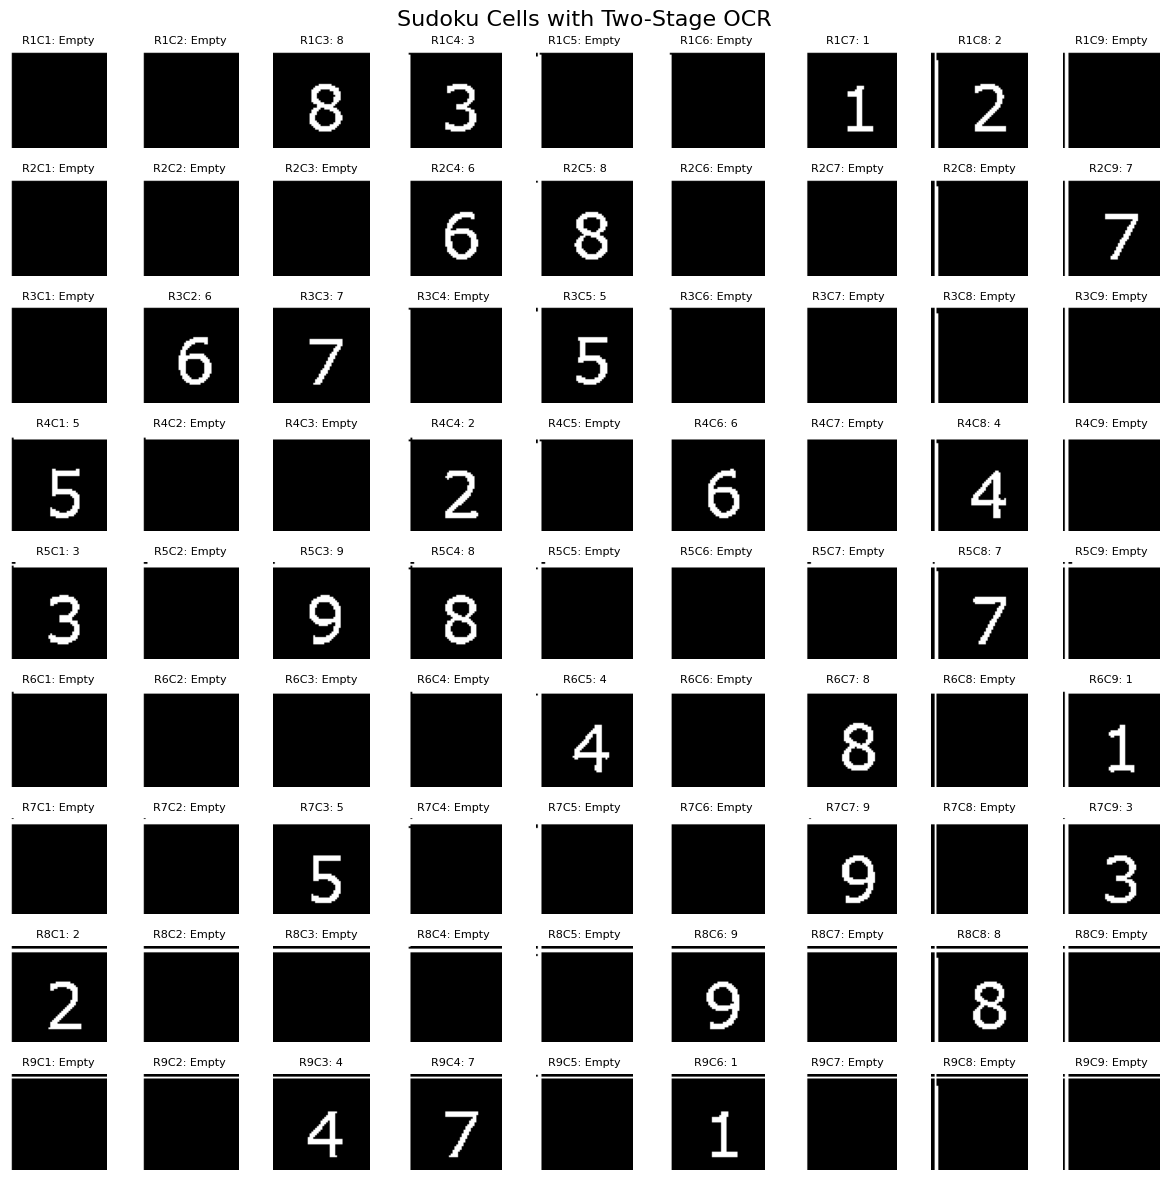


Extracted Sudoku Board:
. | . | 8 | 3 | . | . | 1 | 2 | .
. | . | . | 6 | 8 | . | . | . | 7
. | 6 | 7 | . | 5 | . | . | . | .
-------------------------
5 | . | . | 2 | . | 6 | . | 4 | .
3 | . | 9 | 8 | . | . | . | 7 | .
. | . | . | . | 4 | . | 8 | . | 1
-------------------------
. | . | 5 | . | . | . | 9 | . | 3
2 | . | . | . | . | 9 | . | 8 | .
. | . | 4 | 7 | . | 1 | . | . | .

Filled cells: 30/81
Empty cells: 51/81
✓ Sudoku grid extraction completed successfully!


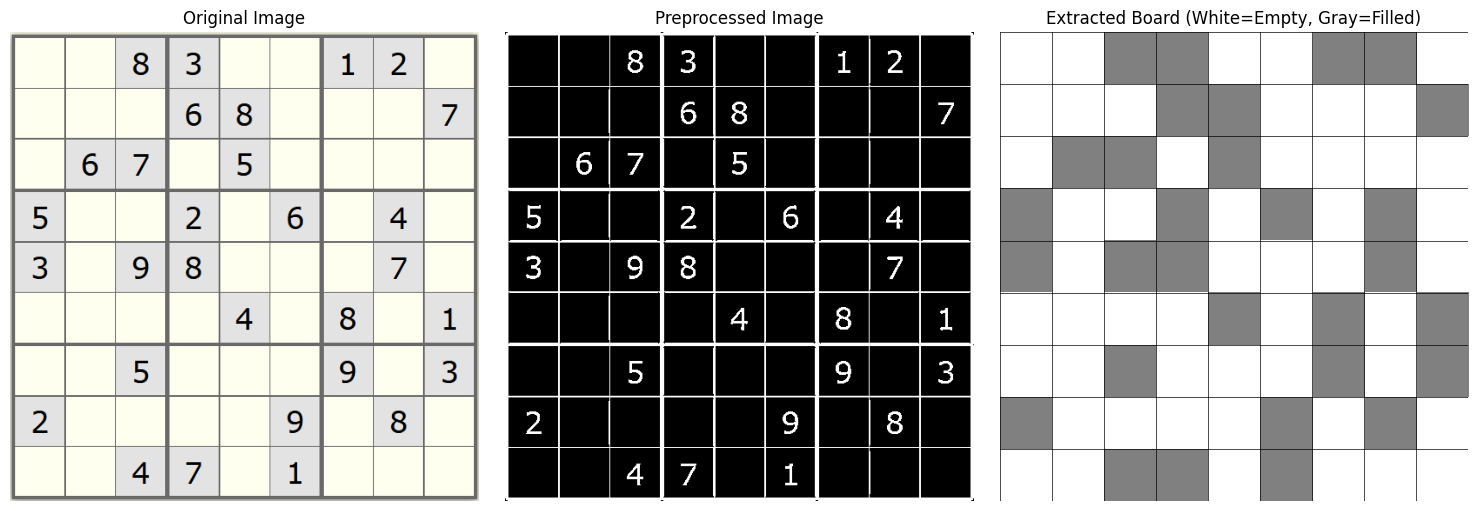


COMPARISON WITH MASTER KEY
Enhanced OCR Accuracy: 100.0%

Detailed Comparison:
Master Key (Reference):
. | . | 8 | 3 | . | . | 1 | 2 | .
. | . | . | 6 | 8 | . | . | . | 7
. | 6 | 7 | . | 5 | . | . | . | .
-------------------------
5 | . | . | 2 | . | 6 | . | 4 | .
3 | . | 9 | 8 | . | . | . | 7 | .
. | . | . | . | 4 | . | 8 | . | 1
-------------------------
. | . | 5 | . | . | . | 9 | . | 3
2 | . | . | . | . | 9 | . | 8 | .
. | . | 4 | 7 | . | 1 | . | . | .

Enhanced OCR Result:
. | . | 8 | 3 | . | . | 1 | 2 | .
. | . | . | 6 | 8 | . | . | . | 7
. | 6 | 7 | . | 5 | . | . | . | .
-------------------------
5 | . | . | 2 | . | 6 | . | 4 | .
3 | . | 9 | 8 | . | . | . | 7 | .
. | . | . | . | 4 | . | 8 | . | 1
-------------------------
. | . | 5 | . | . | . | 9 | . | 3
2 | . | . | . | . | 9 | . | 8 | .
. | . | 4 | 7 | . | 1 | . | . | .

Differences (Master vs Enhanced OCR):
  No differences found!


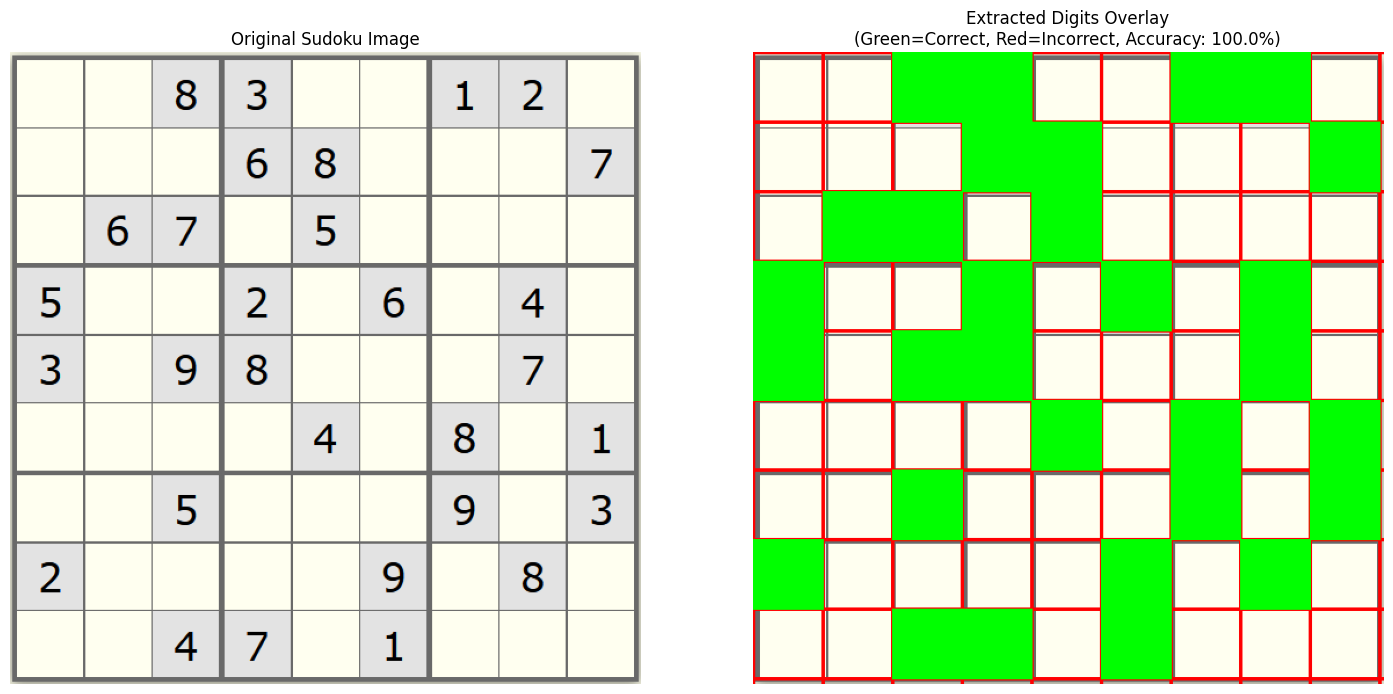

In [12]:
# Test cell for extract_sudoku_grid function
print("Testing extract_sudoku_grid function...")

# Load and preprocess the image first
image_path = "images/sudoku_grid1.png"
try:
    original_image = read_sudoku_image(image_path, debug=False)
    processed_image = preprocess_sudoku_image(original_image)
    
    print("Testing enhanced OCR extraction with confidence-based reprocessing...")
    print("This may take longer due to multiple OCR attempts per cell...")
    
    # Extract the Sudoku grid using enhanced OCR
    sudoku_board = extract_sudoku_grid(processed_image, debug=True)
    
    print("✓ Sudoku grid extraction completed successfully!")
    
    # Display the final result
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(processed_image, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    # Create a visual representation of the extracted board
    board_display = np.zeros((9, 9, 3), dtype=np.uint8)
    for i in range(9):
        for j in range(9):
            if sudoku_board[i, j] != 0:
                board_display[i, j] = [128, 128, 128]  # Gray for filled cells
            else:
                board_display[i, j] = [255, 255, 255]  # White for empty cells
    
    plt.imshow(board_display)
    plt.title("Extracted Board (White=Empty, Gray=Filled)")
    plt.axis('off')
    
    # Add grid lines
    for i in range(10):
        plt.axhline(i - 0.5, color='black', linewidth=0.5)
        plt.axvline(i - 0.5, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Compare with master key if available
    print("\n" + "="*70)
    print("COMPARISON WITH MASTER KEY")
    print("="*70)
    
    # Master key from the optimization test
    master_key = np.array([
        [0, 0, 8, 3, 0, 0, 1, 2, 0],
        [0, 0, 0, 6, 8, 0, 0, 0, 7],
        [0, 6, 7, 0, 5, 0, 0, 0, 0],
        [5, 0, 0, 2, 0, 6, 0, 4, 0],
        [3, 0, 9, 8, 0, 0, 0, 7, 0],
        [0, 0, 0, 0, 4, 0, 8, 0, 1],
        [0, 0, 5, 0, 0, 0, 9, 0, 3],
        [2, 0, 0, 0, 0, 9, 0, 8, 0],
        [0, 0, 4, 7, 0, 1, 0, 0, 0]
    ])
    
    # Calculate accuracy
    def calculate_accuracy(extracted_board: np.ndarray, master_key: np.ndarray) -> float:
        """Calculate accuracy compared to master key."""
        if extracted_board.shape != master_key.shape:
            return 0.0
        
        correct = 0
        total = 0
        
        for i in range(9):
            for j in range(9):
                if master_key[i, j] != 0:  # Only check cells that should have digits
                    total += 1
                    if extracted_board[i, j] == master_key[i, j]:
                        correct += 1
        
        return (correct / total * 100) if total > 0 else 0.0
    
    accuracy = calculate_accuracy(sudoku_board, master_key)
    print(f"Enhanced OCR Accuracy: {accuracy:.1f}%")
    
    # Show detailed comparison
    print("\nDetailed Comparison:")
    print("Master Key (Reference):")
    print_sudoku_board(master_key)
    
    print("\nEnhanced OCR Result:")
    print_sudoku_board(sudoku_board)
    
    # Show differences
    print("\nDifferences (Master vs Enhanced OCR):")
    differences = []
    for i in range(9):
        for j in range(9):
            if master_key[i, j] != 0:  # Only check cells that should have digits
                if sudoku_board[i, j] != master_key[i, j]:
                    differences.append(f"Cell ({i+1},{j+1}): Expected {master_key[i, j]}, Got {sudoku_board[i, j] if sudoku_board[i, j] != 0 else 'Empty'}")
    
    if differences:
        for diff in differences:
            print(f"  {diff}")
    else:
        print("  No differences found!")
    
    # Visual comparison with overlay
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Sudoku Image')
    axes[0].axis('off')
    
    # Create overlay visualization
    def create_overlay_visualization(original_img, extracted_board, master_key):
        """Create an overlay visualization showing extracted digits on the original image."""
        # Convert original image to RGB
        original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        height, width = original_rgb.shape[:2]
        
        # Calculate cell dimensions
        cell_height = height // 9
        cell_width = width // 9
        
        # Create a copy for overlay
        overlay_img = original_rgb.copy()
        
        # Draw grid lines
        for i in range(10):
            # Vertical lines
            cv2.line(overlay_img, (i * cell_width, 0), (i * cell_width, height), (255, 0, 0), 2)
            # Horizontal lines
            cv2.line(overlay_img, (0, i * cell_height), (width, i * cell_height), (255, 0, 0), 2)
        
        # Overlay extracted digits
        for row in range(9):
            for col in range(9):
                if extracted_board[row, col] != 0:
                    # Calculate cell boundaries
                    x1 = col * cell_width
                    y1 = row * cell_height
                    x2 = (col + 1) * cell_width
                    y2 = (row + 1) * cell_height
                    
                    # Check if this digit matches the master key
                    is_correct = (master_key[row, col] == extracted_board[row, col])
                    # Use RGB color values since overlay_img is in RGB format
                    color = (0, 255, 0) if is_correct else (255, 0, 0)  # Green if correct, red if incorrect
                    
                    # Draw highlighted rectangle
                    cv2.rectangle(overlay_img, (x1, y1), (x2, y2), color, -1)
                    
                    # Add semi-transparent overlay
                    overlay_color = np.array(color, dtype=np.uint8)
                    alpha = 0.3  # Transparency factor
                    overlay_img[y1:y2, x1:x2] = cv2.addWeighted(
                        overlay_img[y1:y2, x1:x2], 1 - alpha, 
                        np.full((y2-y1, x2-x1, 3), overlay_color), alpha, 0
                    )
        
        return overlay_img
    
    # Create overlay visualization
    overlay_img = create_overlay_visualization(original_image, sudoku_board, master_key)
    
    # Display overlay
    axes[1].imshow(overlay_img)
    axes[1].set_title(f'Extracted Digits Overlay\n(Green=Correct, Red=Incorrect, Accuracy: {accuracy:.1f}%)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"✗ Error in grid extraction: {e}")
    import traceback
    traceback.print_exc()


In [13]:
import os
import glob

Testing Sudoku extraction on all images...
Debug mode enabled for: None
To enable debug mode for specific images, add filenames to DEBUG_IMAGES list
Found 10 images to process
Processing: empty_sudoku_grid1.png
✓ Completed. Accuracy: 100.0%
Skipping grid1.jpg (no master key available)
Processing: sudoku_grid1.png
✓ Completed. Accuracy: 100.0%
Processing: sudoku_grid2.png
✓ Completed. Accuracy: 100.0%
Processing: sudoku_grid3.png
✓ Completed. Accuracy: 96.3%
Processing: sudoku_grid4.png
✓ Completed. Accuracy: 100.0%
Processing: sudoku_grid5.png
✓ Completed. Accuracy: 100.0%
Processing: sudoku_grid6.png
✓ Completed. Accuracy: 98.8%
Processing: sudoku_grid7.png
✓ Completed. Accuracy: 97.5%
Skipping test_grid.png (no master key available)

Displaying overlay visualizations for 8 images...


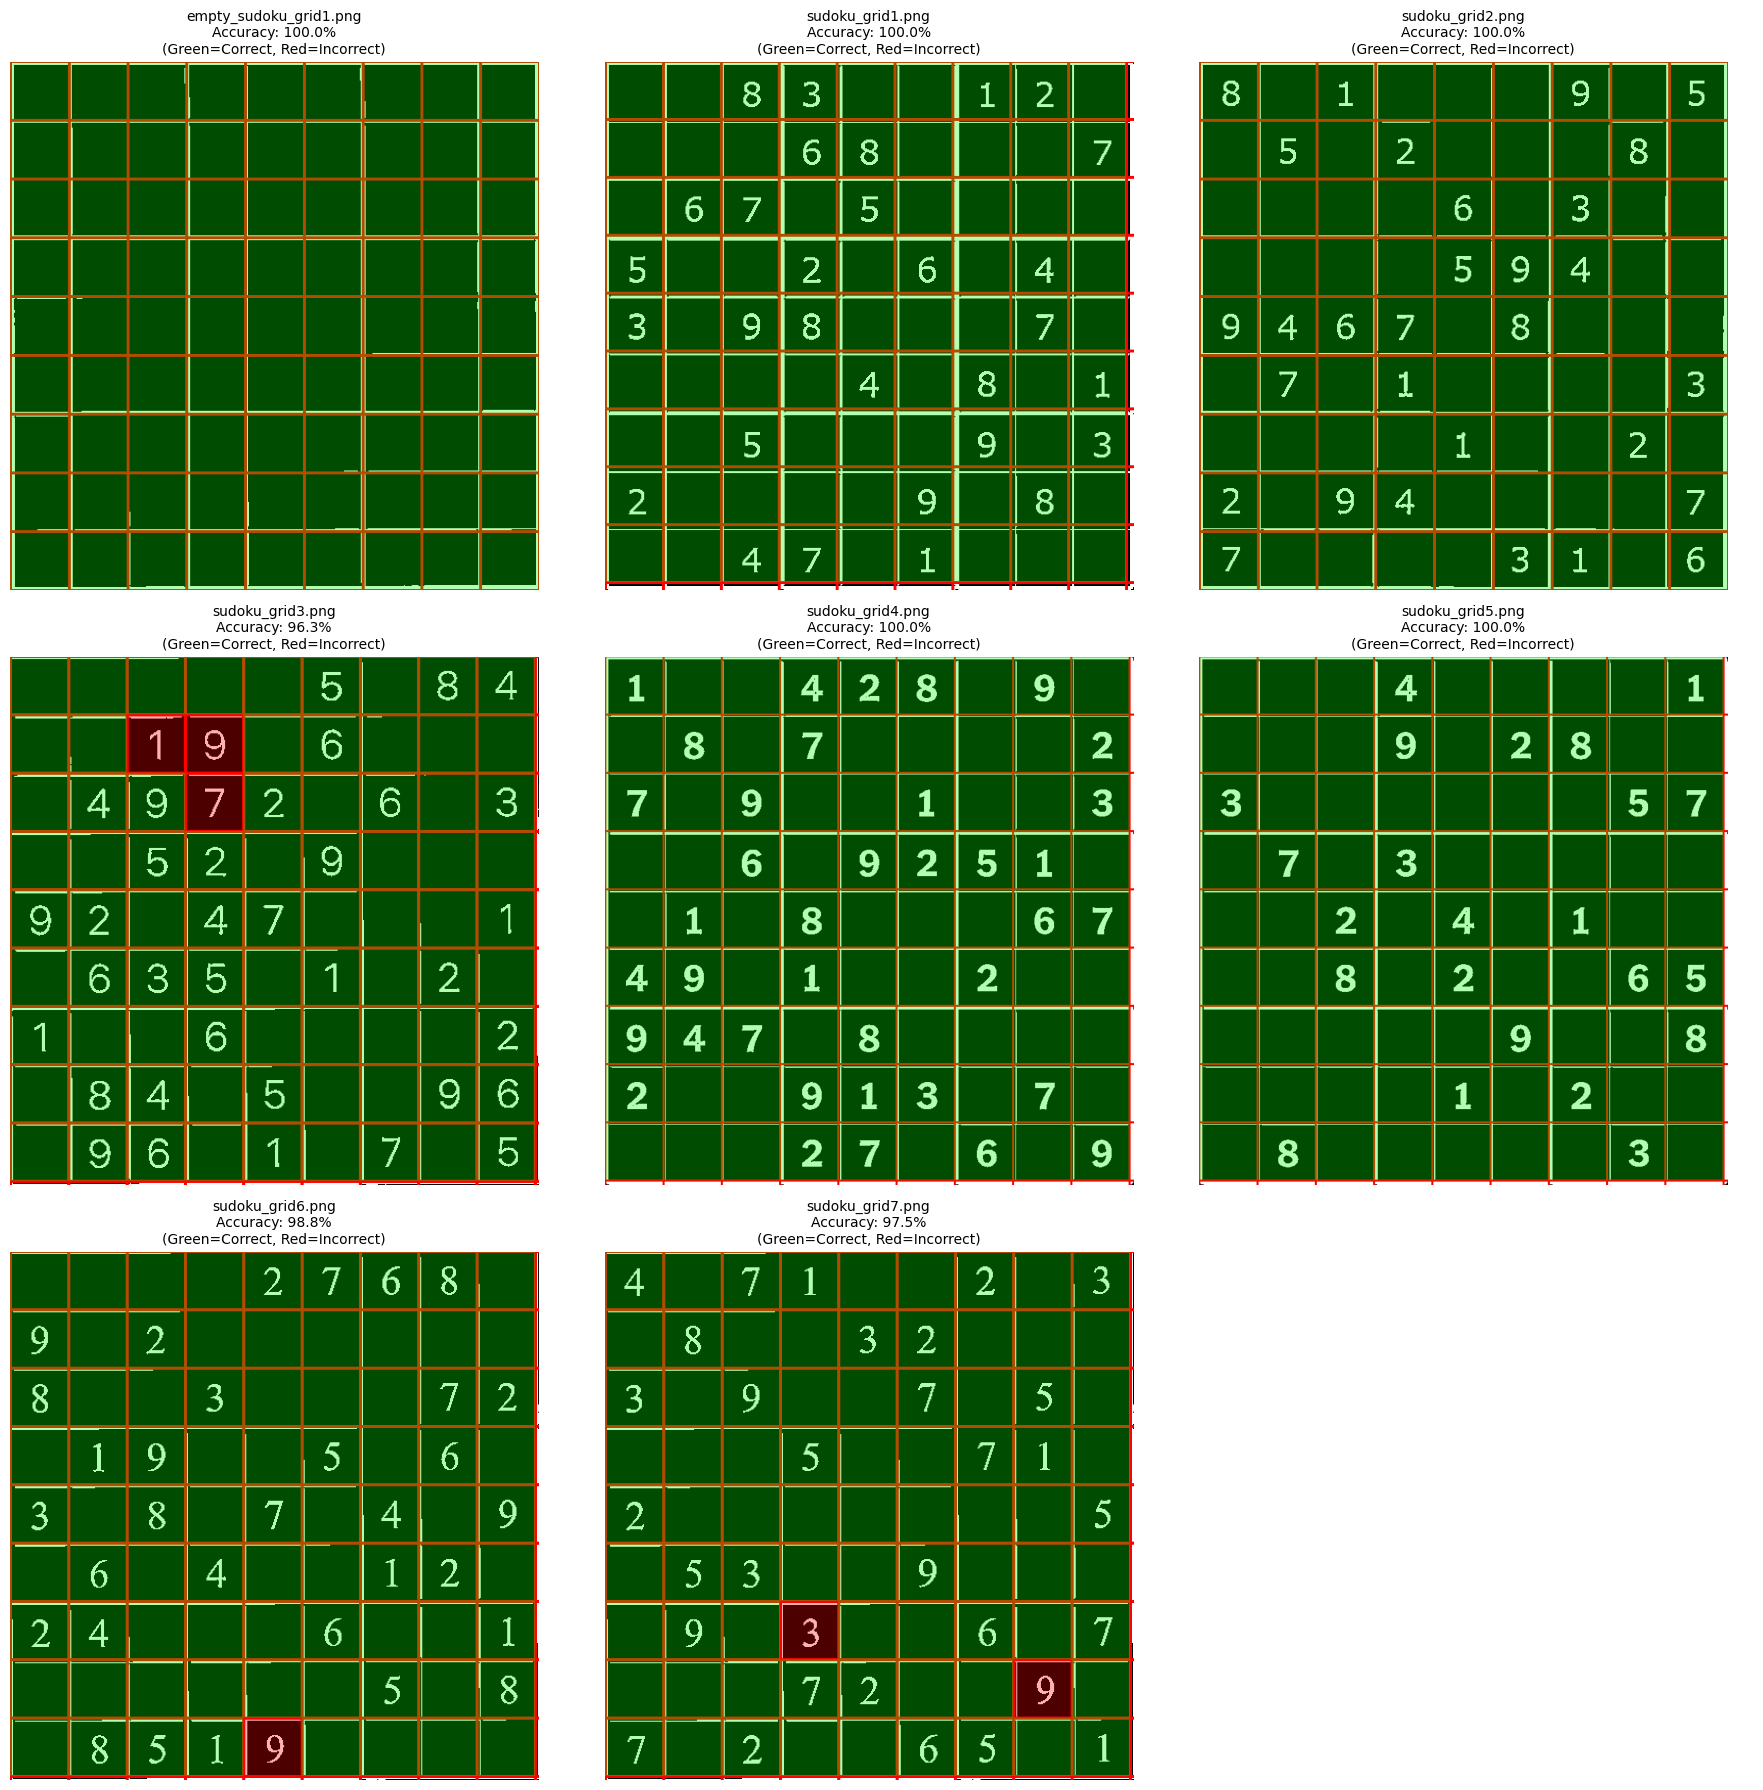


Summary: 8 images processed
Average accuracy: 99.1%


In [14]:
# Master keys for known Sudoku puzzles
MASTER_KEYS = {
    "empty_sudoku_grid1.png": np.array([
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]),
    "sudoku_grid1.png": np.array([
        [0, 0, 8, 3, 0, 0, 1, 2, 0],
        [0, 0, 0, 6, 8, 0, 0, 0, 7],
        [0, 6, 7, 0, 5, 0, 0, 0, 0],
        [5, 0, 0, 2, 0, 6, 0, 4, 0],
        [3, 0, 9, 8, 0, 0, 0, 7, 0],
        [0, 0, 0, 0, 4, 0, 8, 0, 1],
        [0, 0, 5, 0, 0, 0, 9, 0, 3],
        [2, 0, 0, 0, 0, 9, 0, 8, 0],
        [0, 0, 4, 7, 0, 1, 0, 0, 0]
    ]),
    "sudoku_grid2.png": np.array([
        [8, 0, 1, 0, 0, 0, 9, 0, 5],
        [0, 5, 0, 2, 0, 0, 0, 8, 0],
        [0, 0, 0, 0, 6, 0, 3, 0, 0],
        [0, 0, 0, 0, 5, 9, 4, 0, 0],
        [9, 4, 6, 7, 0, 8, 0, 0, 0],
        [0, 7, 0, 1, 0, 0, 0, 0, 3],
        [0, 0, 0, 0, 1, 0, 0, 2, 0],
        [2, 0, 9, 4, 0, 0, 0, 0, 7],
        [7, 0, 0, 0, 0, 3, 1, 0, 6]
    ]),
     "sudoku_grid3.png": np.array([
        [0, 0, 0, 0, 0, 5, 0, 8, 4],
        [0, 0, 1, 9, 0, 6, 0, 0, 0],
        [0, 4, 9, 7, 2, 0, 6, 0, 3],
        [0, 0, 5, 2, 0, 9, 0, 0, 0],
        [9, 2, 0, 4, 7, 0, 0, 0, 1],
        [0, 6, 3, 5, 0, 1, 0, 2, 0],
        [1, 0, 0, 6, 0, 0, 0, 0, 2],
        [0, 8, 4, 0, 5, 0, 0, 9, 6],
        [0, 9, 6, 0, 1, 0, 7, 0, 5]
    ]),
    "sudoku_grid4.png": np.array([
        [1, 0, 0, 4, 2, 8, 0, 9, 0],
        [0, 8, 0, 7, 0, 0, 0, 0, 2],
        [7, 0, 9, 0, 0, 1, 0, 0, 3],
        [0, 0, 6, 0, 9, 2, 5, 1, 0],
        [0, 1, 0, 8, 0, 0, 0, 6, 7],
        [4, 9, 0, 1, 0, 0, 2, 0, 0],
        [9, 4, 7, 0, 8, 0, 0, 0, 0],
        [2, 0, 0, 9, 1, 3, 0, 7, 0],
        [0, 0, 0, 2, 7, 0, 6, 0, 9]
    ]),
    "sudoku_grid5.png": np.array([
        [0, 0, 0, 4, 0, 0, 0, 0, 1],
        [0, 0, 0, 9, 0, 2, 8, 0, 0],
        [3, 0, 0, 0, 0, 0, 0, 5, 7],
        [0, 7, 0, 3, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 4, 0, 1, 0, 0],
        [0, 0, 8, 0, 2, 0, 0, 6, 5],
        [0, 0, 0, 0, 0, 9, 0, 0, 8],
        [0, 0, 0, 0, 1, 0, 2, 0, 0],
        [0, 8, 0, 0, 0, 0, 0, 3, 0]
    ]),
    "sudoku_grid6.png": np.array([
        [0, 0, 0, 0, 2, 7, 6, 8, 0],
        [9, 0, 2, 0, 0, 0, 0, 0, 0],
        [8, 0, 0, 3, 0, 0, 0, 7, 2],
        [0, 1, 9, 0, 0, 5, 0, 6, 0],
        [3, 0, 8, 0, 7, 0, 4, 0, 9],
        [0, 6, 0, 4, 0, 0, 1, 2, 0],
        [2, 4, 0, 0, 0, 6, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 5, 0, 8],
        [0, 8, 5, 1, 9, 0, 0, 0, 0]
    ]),
    "sudoku_grid7.png": np.array([
        [4, 0, 7, 1, 0, 0, 2, 0, 3],
        [0, 8, 0, 0, 3, 2, 0, 0, 0],
        [3, 0, 9, 0, 0, 7, 0, 5, 0],
        [0, 0, 0, 5, 0, 0, 7, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 5, 3, 0, 0, 9, 0, 0, 0],
        [0, 9, 0, 0, 0, 0, 6, 0, 7],
        [0, 0, 0, 7, 2, 0, 0, 9, 0],
        [7, 0, 2, 0, 0, 6, 5, 0, 1]
    ]),
    
}

IMAGE_NAMES = MASTER_KEYS.keys()
# Images to run in debug mode (set to empty list to disable debug for all)
DEBUG_IMAGES = []  # Add filenames here to enable debug mode

def calculate_accuracy(extracted_board, master_key):
    """Calculate accuracy compared to master key."""
    if extracted_board.shape != master_key.shape:
        return 0.0
    
    correct = 0
    total = 0
    
    for i in range(9):
        for j in range(9):
            total += 1
            if extracted_board[i, j] == master_key[i, j]:
                correct += 1
    
    return (correct / total * 100) if total > 0 else 0.0

def create_overlay_visualization(original_img, extracted_board, master_key):
    """Create an overlay visualization showing extracted digits on the original image."""
    # Convert original image to RGB
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    height, width = original_rgb.shape[:2]
    
    # Calculate cell dimensions
    cell_height = height // 9
    cell_width = width // 9
    
    # Create a copy for overlay
    overlay_img = original_rgb.copy()
    
    # Draw grid lines
    for i in range(10):
        # Vertical lines
        cv2.line(overlay_img, (i * cell_width, 0), (i * cell_width, height), (255, 0, 0), 2)
        # Horizontal lines
        cv2.line(overlay_img, (0, i * cell_height), (width, i * cell_height), (255, 0, 0), 2)
    
    # Overlay extracted digits
    for row in range(9):
        for col in range(9):
            # Calculate cell boundaries
            x1 = col * cell_width
            y1 = row * cell_height
            x2 = (col + 1) * cell_width
            y2 = (row + 1) * cell_height
            
            # Check if this digit matches the master key
            is_correct = (master_key[row, col] == extracted_board[row, col])
            # Use RGB color values
            color = (0, 255, 0) if is_correct else (255, 0, 0)  # Green if correct, red if incorrect
            
            # Add semi-transparent overlay
            alpha = 0.3
            overlay_color = np.full((y2-y1, x2-x1, 3), color, dtype=np.uint8)
            if (y2-y1) > 0 and (x2-x1) > 0:  # Ensure valid dimensions
                overlay_img[y1:y2, x1:x2] = cv2.addWeighted(
                    overlay_img[y1:y2, x1:x2], 1 - alpha, 
                    overlay_color, alpha, 0
                )
    
    return overlay_img

# Print instructions for using debug mode
print("Testing Sudoku extraction on all images...")
print(f"Debug mode enabled for: {DEBUG_IMAGES if DEBUG_IMAGES else 'None'}")
print("To enable debug mode for specific images, add filenames to DEBUG_IMAGES list")

# Get all image files
image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff']
image_files = []

for ext in image_extensions:
    pattern = os.path.join("images", ext)
    image_files.extend(glob.glob(pattern))

image_files = sorted(image_files)
if not image_files:
    print("No image files found in 'images' folder.")

print(f"Found {len(image_files)} images to process")

# Process each image
successful_results = []

for image_path in image_files:
    filename = os.path.basename(image_path)
    if filename not in IMAGE_NAMES:
        print(f"Skipping {filename} (no master key available)")
        continue

    # Check if debug mode should be enabled for this image
    debug_mode = filename in DEBUG_IMAGES
    debug_status = " (DEBUG MODE)" if debug_mode else ""
    print(f"Processing: {filename}{debug_status}")
    
    try:
        # Load and preprocess the image
        original_image = read_sudoku_image(image_path, debug=False)
        processed_image = preprocess_sudoku_image(original_image)
        
        # Extract the Sudoku grid (debug=False for clean output)
        sudoku_board = extract_sudoku_grid(processed_image, debug=debug_mode)
        
        # Check if we have a master key for this image
        if filename in MASTER_KEYS:
            master_key = MASTER_KEYS[filename]
            accuracy = calculate_accuracy(sudoku_board, master_key)
            print(f"✓ Completed. Accuracy: {accuracy:.1f}%")
            
            successful_results.append({
                'filename': filename,
                'original_image': original_image,
                'processed_image': processed_image,
                'extracted_board': sudoku_board,
                'master_key': master_key,
                'accuracy': accuracy
            })
        else:
            print("✓ Completed. No master key available.")
            
    except Exception as e:
        print(f"✗ Error: {e}")

# Display overlay visualizations
if successful_results:
    print(f"\nDisplaying overlay visualizations for {len(successful_results)} images...")
    
    # Calculate subplot layout
    n_images = len(successful_results)
    n_cols = min(3, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
    
    # Handle single image case
    if n_images == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
    else:
        axes = axes.flatten()
    
    # Generate and display overlays
    for idx, result in enumerate(successful_results):
        overlay_img = create_overlay_visualization(
            result['processed_image'], 
            result['extracted_board'], 
            result['master_key']
        )
        
        axes[idx].imshow(overlay_img)
        axes[idx].set_title(
            f"{result['filename']}\nAccuracy: {result['accuracy']:.1f}%\n"
            f"(Green=Correct, Red=Incorrect)",
            fontsize=10
        )
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(successful_results), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    avg_accuracy = np.mean([r['accuracy'] for r in successful_results])
    print(f"\nSummary: {len(successful_results)} images processed")
    print(f"Average accuracy: {avg_accuracy:.1f}%")
else:
    print("No successful extractions with master keys to display.")

In [15]:
def solve_sudoku(board: np.ndarray, debug: bool = False) -> Tuple[np.ndarray, bool]:
    """
    Solve a Sudoku puzzle using backtracking algorithm.
    
    Args:
        board (np.ndarray): 9x9 Sudoku board (0 for empty cells)
        debug (bool): If True, shows solving progress
        
    Returns:
        Tuple[np.ndarray, bool]: (solved_board, is_solved)
    """
    if debug:
        print("Starting Sudoku solving process...")
        print("Initial board:")
        print_sudoku_board(board)
    
    # Make a copy to avoid modifying the original
    solved_board = board.copy()
    
    def is_valid(board: np.ndarray, row: int, col: int, num: int) -> bool:
        """Check if placing num at (row, col) is valid."""
        # Check row
        for x in range(9):
            if board[row][x] == num:
                return False
        
        # Check column
        for x in range(9):
            if board[x][col] == num:
                return False
        
        # Check 3x3 box
        start_row = row - row % 3
        start_col = col - col % 3
        for i in range(3):
            for j in range(3):
                if board[i + start_row][j + start_col] == num:
                    return False
        
        return True
    
    def solve(board: np.ndarray) -> bool:
        """Recursive backtracking solver."""
        for row in range(9):
            for col in range(9):
                if board[row][col] == 0:  # Empty cell
                    for num in range(1, 10):
                        if is_valid(board, row, col, num):
                            board[row][col] = num
                            
                            if debug:
                                print(f"Placing {num} at ({row}, {col})")
                            
                            if solve(board):
                                return True
                            
                            board[row][col] = 0  # Backtrack
                            
                            if debug:
                                print(f"Backtracking from ({row}, {col})")
                    
                    return False  # No valid number found
        return True  # All cells filled
    
    # Attempt to solve
    is_solved = solve(solved_board)
    
    if debug:
        if is_solved:
            print("\\n✓ Sudoku solved successfully!")
            print("Final solved board:")
            print_sudoku_board(solved_board)
        else:
            print("\\n✗ Could not solve the Sudoku puzzle")
            print("This might indicate an invalid initial board")
    
    return solved_board, is_solved
def validate_sudoku_board(board: np.ndarray) -> bool:
    """
    Validate if a Sudoku board is correctly solved.
    
    Args:
        board (np.ndarray): 9x9 Sudoku board
        
    Returns:
        bool: True if the board is valid, False otherwise
    """
    # Check rows
    for row in board:
        if len(set(row)) != 9 or 0 in row:
            return False
    
    # Check columns
    for col in range(9):
        column = [board[row][col] for row in range(9)]
        if len(set(column)) != 9 or 0 in column:
            return False
    
    # Check 3x3 boxes
    for box_row in range(3):
        for box_col in range(3):
            box = []
            for i in range(3):
                for j in range(3):
                    box.append(board[box_row * 3 + i][box_col * 3 + j])
            if len(set(box)) != 9 or 0 in box:
                return False
    
    return True


In [16]:
import time
import os

SUDOKU SOLVER TEST SUITE
Found 7 of 7 specified images to process

Processing: sudoku_grid1.png
  1. Loading and preprocessing image...
  2. Extracting Sudoku grid...
  3. Extracted board:
. | . | 8 | 3 | . | . | 1 | 2 | .
. | . | . | 6 | 8 | . | . | . | 7
. | 6 | 7 | . | 5 | . | . | . | .
-------------------------
5 | . | . | 2 | . | 6 | . | 4 | .
3 | . | 9 | 8 | . | . | . | 7 | .
. | . | . | . | 4 | . | 8 | . | 1
-------------------------
. | . | 5 | . | . | . | 9 | . | 3
2 | . | . | . | . | 9 | . | 8 | .
. | . | 4 | 7 | . | 1 | . | . | .
  4. Attempting to solve...
  ✓ SOLVED successfully in 0.00 seconds!
  5. Solved board:
4 | 5 | 8 | 3 | 9 | 7 | 1 | 2 | 6
1 | 3 | 2 | 6 | 8 | 4 | 5 | 9 | 7
9 | 6 | 7 | 1 | 5 | 2 | 4 | 3 | 8
-------------------------
5 | 8 | 1 | 2 | 7 | 6 | 3 | 4 | 9
3 | 4 | 9 | 8 | 1 | 5 | 6 | 7 | 2
7 | 2 | 6 | 9 | 4 | 3 | 8 | 5 | 1
-------------------------
6 | 7 | 5 | 4 | 2 | 8 | 9 | 1 | 3
2 | 1 | 3 | 5 | 6 | 9 | 7 | 8 | 4
8 | 9 | 4 | 7 | 3 | 1 | 2 | 6 | 5

Proces

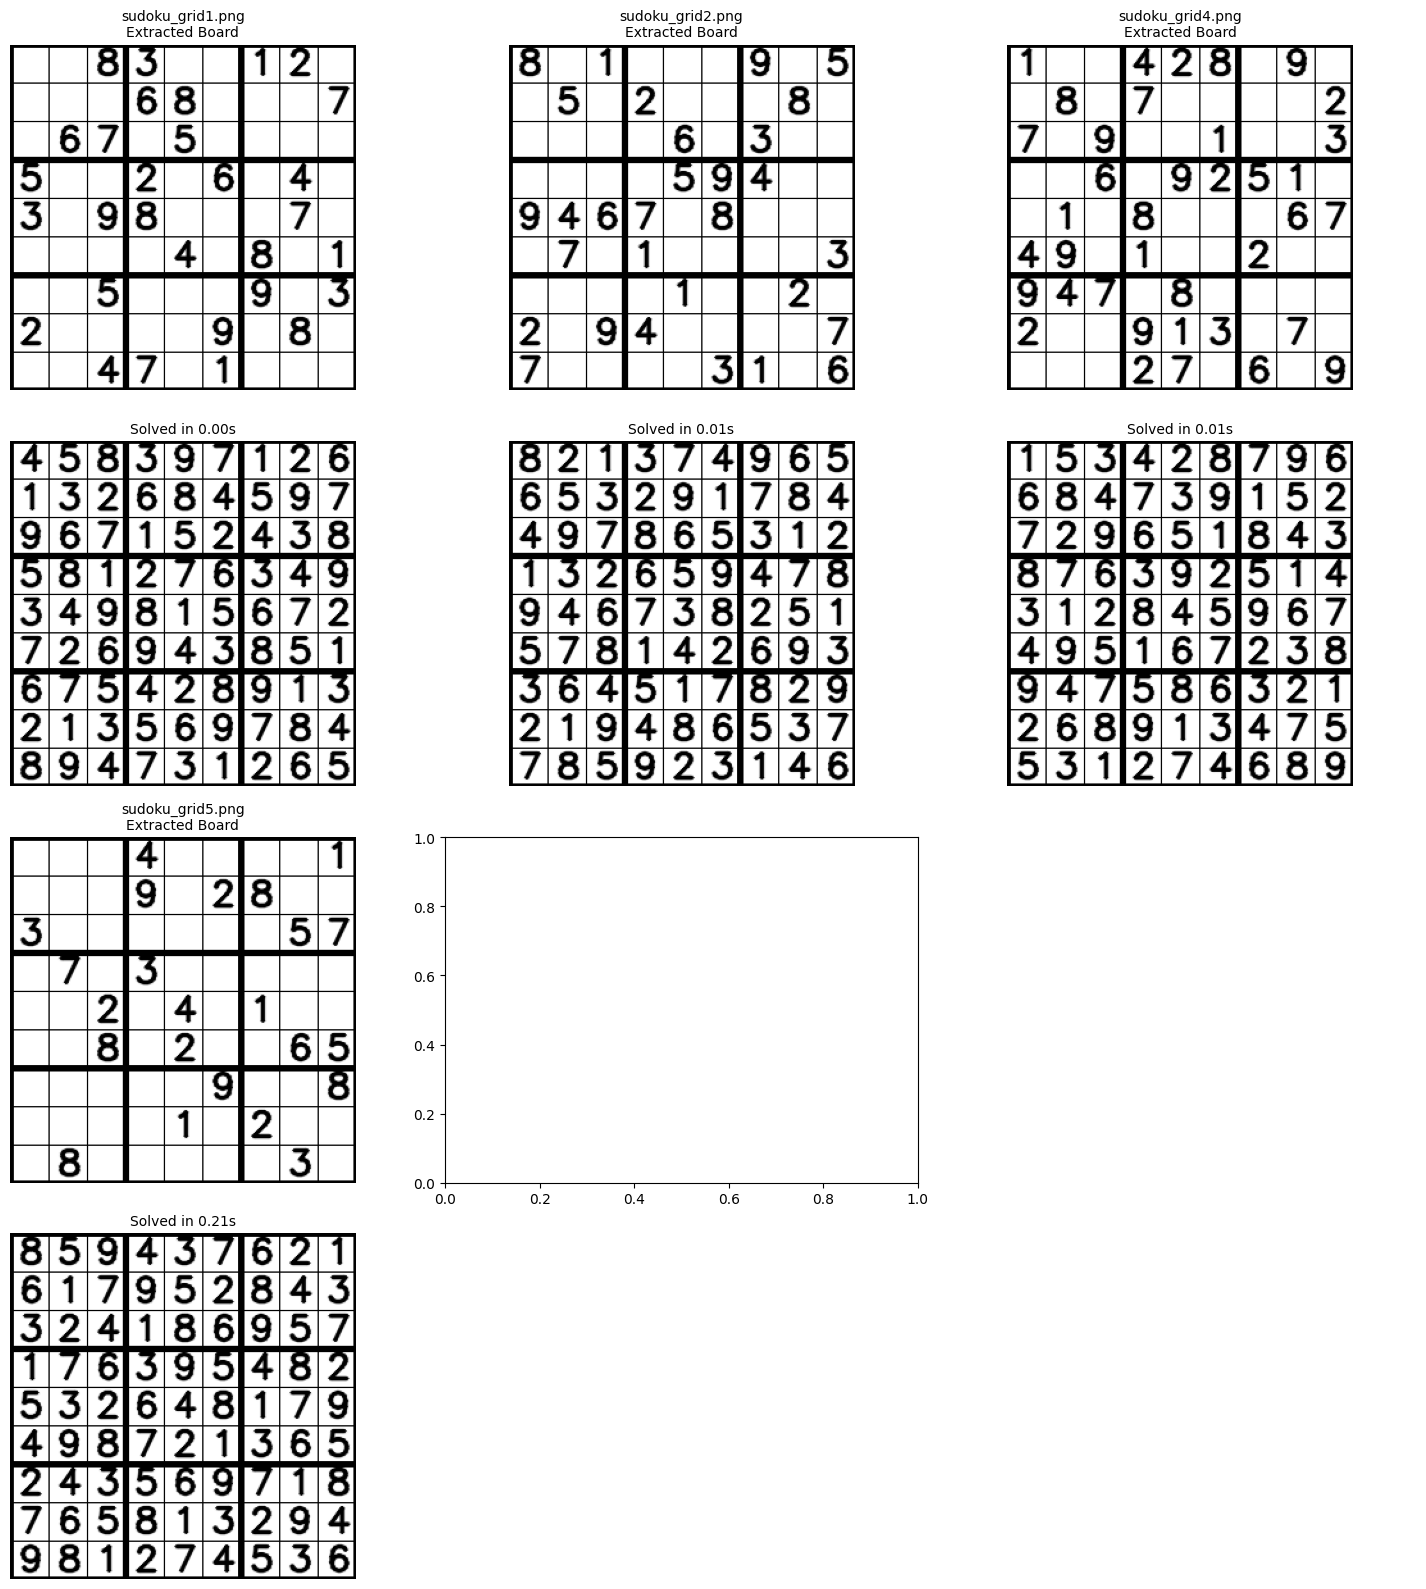

In [17]:
print("="*70)
print("SUDOKU SOLVER TEST SUITE")
print("="*70)

# Specific files to test
file_names_to_test = [
    "sudoku_grid1.png",
    "sudoku_grid2.png",
    "sudoku_grid3.png",
    "sudoku_grid4.png",
    "sudoku_grid5.png",
    "sudoku_grid6.png",
    "sudoku_grid7.png"
]

# Get full paths for specified files
image_files = []
missing_files = []

for filename in file_names_to_test:
    full_path = os.path.join("images", filename)
    if os.path.exists(full_path):
        image_files.append(full_path)
    else:
        missing_files.append(filename)

if missing_files:
    print(f"Warning: {len(missing_files)} files not found:")
    for missing in missing_files:
        print(f"  - {missing}")

if not image_files:
    print("No specified image files found in 'images' folder.")

print(f"Found {len(image_files)} of {len(file_names_to_test)} specified images to process")

# Test results storage
test_results = []

for image_path in image_files:
    filename = os.path.basename(image_path)
    print(f"\nProcessing: {filename}")
    
    try:
        # Step 1: Extract Sudoku grid from image
        print("  1. Loading and preprocessing image...")
        original_image = read_sudoku_image(image_path, debug=False)
        processed_image = preprocess_sudoku_image(original_image, debug=False)
        
        print("  2. Extracting Sudoku grid...")
        extracted_board = extract_sudoku_grid(processed_image, debug=False)
        
        print("  3. Extracted board:")
        print_sudoku_board(extracted_board)
        
        # Step 2: Solve the extracted board
        print("  4. Attempting to solve...")
        start_time = time.time()
        solved_board, is_solved = solve_sudoku(extracted_board, debug=False)
        solve_time = time.time() - start_time
        
        # Step 3: Validate the solution (if solved)
        is_valid = False
        if is_solved:
            is_valid = validate_sudoku_board(solved_board)
        
        # Store results
        result = {
            'filename': filename,
            'extraction_success': True,
            'extracted_board': extracted_board,
            'solve_success': is_solved,
            'solution_valid': is_valid,
            'solved_board': solved_board if is_solved else None,
            'solve_time': solve_time,
            'error_message': None
        }
        
        # Print results
        if is_solved and is_valid:
            print(f"  ✓ SOLVED successfully in {solve_time:.2f} seconds!")
            print("  5. Solved board:")
            print_sudoku_board(solved_board)
        elif is_solved and not is_valid:
            print(f"  ⚠ Solved in {solve_time:.2f} seconds but INVALID solution!")
            print("  5. Invalid solved board:")
            print_sudoku_board(solved_board)
        else:
            print(f"  ✗ FAILED to solve (took {solve_time:.2f} seconds)")
            print("  5. Partial progress:")
            print_sudoku_board(solved_board)
        
        test_results.append(result)
        
    except Exception as e:
        print(f"  ✗ Error during processing: {e}")
        result = {
            'filename': filename,
            'extraction_success': False,
            'extracted_board': None,
            'solve_success': False,
            'solution_valid': False,
            'solved_board': None,
            'solve_time': 0,
            'error_message': str(e)
        }
        test_results.append(result)

print("\n" + "="*70)
print("COMPREHENSIVE TEST RESULTS")
print("="*70)

# Calculate statistics
total_tests = len(test_results)
successful_extractions = sum(1 for r in test_results if r['extraction_success'])
successful_solves = sum(1 for r in test_results if r['solve_success'])
valid_solutions = sum(1 for r in test_results if r['solution_valid'])

print(f"Total images tested: {total_tests}")
print(f"Successful extractions: {successful_extractions}/{total_tests} ({successful_extractions/total_tests*100:.1f}%)")
print(f"Successful solves: {successful_solves}/{successful_extractions} ({successful_solves/successful_extractions*100:.1f}% of extracted)")
print(f"Valid solutions: {valid_solutions}/{successful_solves} ({valid_solutions/successful_solves*100:.1f}% of solved)" if successful_solves > 0 else "Valid solutions: 0/0")

# Show timing statistics
solve_times = [r['solve_time'] for r in test_results if r['solve_success']]
if solve_times:
    print(f"\nSolving time statistics:")
    print(f"  Average: {np.mean(solve_times):.2f} seconds")
    print(f"  Median: {np.median(solve_times):.2f} seconds")
    print(f"  Min: {min(solve_times):.2f} seconds")
    print(f"  Max: {max(solve_times):.2f} seconds")

# Detailed results by image
print(f"\nDetailed Results:")
print("-" * 70)
for result in test_results:
    status_icons = []
    if result['extraction_success']:
        status_icons.append("📥")
    if result['solve_success']:
        status_icons.append("🧩")
    if result['solution_valid']:
        status_icons.append("✅")
    
    status_str = "".join(status_icons) if status_icons else "❌"
    time_str = f"({result['solve_time']:.2f}s)" if result['solve_success'] else ""
    
    print(f"{result['filename']:25} {status_str} {time_str}")
    if result['error_message']:
        print(f"                          Error: {result['error_message']}")

print(f"\nLegend: 📥=Extracted, 🧩=Solved, ✅=Valid")

# Create visualizations for successful cases
successful_results = [r for r in test_results if r['solve_success'] and r['solution_valid']]

if successful_results:
    print(f"\nGenerating visualizations for {len(successful_results)} successful solutions...")

    n_results = len(successful_results)
    if n_results == 0:
        print("No successful solutions to visualize.")
        exit(0)

    # Calculate layout
    n_cols = min(3, n_results)
    n_rows = (n_results + n_cols - 1) // n_cols

    # Create figure for before/after comparison
    fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(5*n_cols, 8*n_rows))

    # Ensure axes is always a 2D array for consistent indexing
    if n_results == 1:
        axes = np.array([[axes[0]], [axes[1]]]) if isinstance(axes, np.ndarray) and axes.size == 2 else np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(2, -1)
    elif isinstance(axes, np.ndarray):
        axes = axes.reshape(n_rows * 2, n_cols)

    def board_to_image(board):
        """Convert board to visual representation."""
        img = np.ones((270, 270, 3), dtype=np.uint8) * 255  # White background

        # Draw grid lines
        for i in range(10):
            thickness = 3 if i % 3 == 0 else 1
            # Vertical lines
            cv2.line(img, (i*30, 0), (i*30, 270), (0, 0, 0), thickness)
            # Horizontal lines
            cv2.line(img, (0, i*30), (270, i*30), (0, 0, 0), thickness)

        # Add numbers
        for row in range(9):
            for col in range(9):
                if board[row, col] != 0:
                    x = col * 30 + 7
                    y = row * 30 + 23
                    cv2.putText(img, str(board[row, col]), (x, y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2, cv2.LINE_AA)
        return img

    for idx, result in enumerate(successful_results):
        col_idx = idx % n_cols
        row_pair = idx // n_cols

        # Before (extracted)
        before_img = board_to_image(result['extracted_board'])
        axes[row_pair * 2, col_idx].imshow(before_img)
        axes[row_pair * 2, col_idx].set_title(f"{result['filename']}\nExtracted Board", fontsize=10)
        axes[row_pair * 2, col_idx].axis('off')

        # After (solved)
        after_img = board_to_image(result['solved_board'])
        axes[row_pair * 2 + 1, col_idx].imshow(after_img)
        axes[row_pair * 2 + 1, col_idx].set_title(f"Solved in {result['solve_time']:.2f}s", fontsize=10)
        axes[row_pair * 2 + 1, col_idx].axis('off')

    # Hide unused subplots
    total_subplots = n_rows * n_cols * 2
    used_subplots = len(successful_results) * 2
    for idx in range(used_subplots, total_subplots):
        row_idx = idx // n_cols
        col_idx = idx % n_cols
        axes[row_idx, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
    # def multi_method_ocr(cell_variants: list) -> tuple:
    #     """
    #     Apply multiple OCR methods and return the most confident result.
        
    #     Returns: 
    #         tuple: (digit, confidence)
    #     """
    #     results = []
        
    #     # Tesseract configurations
    #     tesseract_configs = ['--oem 3 --psm 10 -c tessedit_char_whitelist=123456789']
        
    #     # Try each cell variant with each config
    #     for cell_variant in cell_variants:
    #         for config in tesseract_configs:
    #             try:
    #                 # Get text and confidence from Tesseract
    #                 data = pytesseract.image_to_data(cell_variant, config=config, output_type=pytesseract.Output.DICT)
    #                 confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
    #                 text = pytesseract.image_to_string(cell_variant, config=config).strip()
                    
    #                 for char in text:
    #                     if char.isdigit() and '1' <= char <= '9':
    #                         avg_confidence = np.mean(confidences) if confidences else 0
    #                         results.append((int(char), avg_confidence, 'tesseract'))
    #                         break
    #             except:
    #                 continue
        
    #     # Try EasyOCR if available
    #     if use_easyocr:
    #         for cell_variant in cell_variants:
    #             try:
    #                 easyocr_results = reader.readtext(cell_variant, allowlist='123456789', width_ths=0.1)
    #                 for (bbox, text, confidence) in easyocr_results:
    #                     text = text.strip()
    #                     if text.isdigit() and '1' <= text <= '9':
    #                         # EasyOCR confidence is 0-1, convert to 0-100
    #                         results.append((int(text), confidence * 100, 'easyocr'))
    #             except:
    #                 continue
        
    #     if not results:
    #         return None, 0
        
    #     # Weight the results - EasyOCR tends to be more accurate
    #     weighted_results = []
    #     for digit, conf, method in results:
    #         if method == 'easyocr':
    #             weighted_results.append((digit, conf * 1.2))  # Boost EasyOCR confidence
    #         else:
    #             weighted_results.append((digit, conf))
        
    #     # Find the most confident result
    #     best_result = max(weighted_results, key=lambda x: x[1])
        
    #     # Additional validation: check if multiple methods agree
    #     digit_counts = {}
    #     for digit, conf in weighted_results:
    #         if digit not in digit_counts:
    #             digit_counts[digit] = []
    #         digit_counts[digit].append(conf)
        
    #     # If multiple methods agree on the same digit, boost confidence
    #     if len(digit_counts.get(best_result[0], [])) > 1:
    #         best_result = (best_result[0], min(best_result[1] * 1.3, 100))
        
    #     return best_result[0], best_result[1]

    # # Process each cell
    # for row in range(9):
    #     for col in range(9):
    #         if debug:
    #             print(f"Processing cell ({row+1}, {col+1})...")
            
    #         # Calculate cell boundaries with small margin to avoid grid lines
    #         margin = 2
    #         y1 = row * cell_height + margin
    #         y2 = (row + 1) * cell_height - margin
    #         x1 = col * cell_width + margin
    #         x2 = (col + 1) * cell_width - margin
            
    #         # Extract cell image
    #         cell = processed_image[y1:y2, x1:x2]
            
    #         # Enhanced content detection
    #         has_content, confidence, binary_cell = content_detection(cell)
            
    #         if debug:
    #             print(f"  Content detection - Has content: {has_content}, Confidence: {confidence:.1f}")
            
    #         # Require higher confidence for truly empty cells
    #         if not has_content or confidence < 25:
    #             if debug:
    #                 print(f"  Cell marked as empty (low confidence: {confidence:.1f})")
    #             sudoku_board[row, col] = 0
    #         else:
    #             # Cell has content, try OCR with multiple methods
    #             digit, ocr_confidence = multi_method_ocr(cell)
                
    #             if debug:
    #                 print(f"  OCR result - Digit: {digit}, Confidence: {ocr_confidence:.1f}")
                
    #             # Only accept high-confidence OCR results
    #             if digit is not None and ocr_confidence > 30:
    #                 sudoku_board[row, col] = digit
    #                 if debug:
    #                     print(f"  Accepted digit: {digit}")
    #             else:
    #                 if debug:
    #                     print(f"  OCR confidence too low, marking as empty")
    #                 sudoku_board[row, col] = 0
            
    #         if debug:
    #             # Display the cell with result
    #             axes[row, col].imshow(cell, cmap='gray')
    #             title = f"R{row+1}C{col+1}: {sudoku_board[row, col] if sudoku_board[row, col] != 0 else 'Empty'}"
    #             if has_content:
    #                 title += f" (C:{confidence:.0f})"
    #             axes[row, col].set_title(title, fontsize=8)
    #             axes[row, col].axis('off')
    
    # if debug:
    #     plt.tight_layout()
    #     plt.show()
        
    #     print("\nExtracted Sudoku Board:")
    #     print("=" * 25)
    #     for i, row in enumerate(sudoku_board):
    #         if i % 3 == 0 and i != 0:
    #             print("-" * 25)
    #         row_str = " | ".join([str(x) if x != 0 else "." for x in row])
    #         print(f"{row_str}")
    #     print("=" * 25)
        
    #     # Count filled cells
    #     filled_cells = np.count_nonzero(sudoku_board)
    #     print(f"\nFilled cells: {filled_cells}/81")
    #     print(f"Empty cells: {81 - filled_cells}/81")
    
    # return sudoku_board
    # if debug:
    #     print("Starting Sudoku grid extraction...")
    
    # # Initialize the 9x9 Sudoku board
    # sudoku_board = np.zeros((9, 9), dtype=int)
    
    # # Calculate cell dimensions
    # height, width = processed_image.shape
    # cell_height = height // 9
    # cell_width = width // 9
    
    # if debug:
    #     print(f"Image dimensions: {width}x{height}")
    #     print(f"Cell dimensions: {cell_width}x{cell_height}")
        
    #     # Create a figure to show all cells
    #     fig, axes = plt.subplots(9, 9, figsize=(15, 15))
    #     fig.suptitle("Enhanced Sudoku Cells with Multi-Method OCR", fontsize=16)
    
    # # Initialize EasyOCR reader (more accurate for digits)
    # try:
    #     reader = easyocr.Reader(['en'], gpu=False)
    #     use_easyocr = True
    # except:
    #     use_easyocr = False
    #     if debug:
    #         print("EasyOCR not available, using Tesseract only")
    
    # def content_detection(cell_image: np.ndarray) -> tuple:
    #     """
    #     Content detection with multiple methods.
        
    #     Returns:
    #         tuple: (has_content, confidence_score, processed_cell)
    #     """
    #     # Method 1: Pixel density analysis
    #     non_zero_pixels = np.sum(cell_image > 30)
    #     total_pixels = cell_image.size
    #     pixel_density = non_zero_pixels / total_pixels
        
    #     # Method 2: Connected components analysis
    #     binary = (cell_image > 50).astype(np.uint8)
    #     num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
        
    #     # Filter out small noise components and edge components
    #     significant_components = 0
    #     for i in range(1, num_labels):  # Skip background (label 0)
    #         area = stats[i, cv2.CC_STAT_AREA]
    #         x, y = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
    #         w, h = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            
    #         # Check if component is significant and not just border noise
    #         if (area > 20 and  # Minimum area
    #             x > 2 and y > 2 and  # Not touching edges
    #             x + w < cell_image.shape[1] - 2 and 
    #             y + h < cell_image.shape[0] - 2):
    #             significant_components += 1
        
    #     # Method 3: Morphological analysis
    #     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #     opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    #     contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
    #     # Filter contours by size and position
    #     valid_contours = []
    #     for contour in contours:
    #         area = cv2.contourArea(contour)
    #         x, y, w, h = cv2.boundingRect(contour)
    #         aspect_ratio = w / h if h > 0 else 0
            
    #         if (area > 30 and  # Minimum area
    #             0.2 < aspect_ratio < 5 and  # Reasonable aspect ratio
    #             x > 2 and y > 2):  # Not touching edges
    #             valid_contours.append(contour)
        
    #     # Calculate confidence score
    #     confidence = 0
    #     confidence += min(pixel_density * 50, 30)  # Up to 30 points for pixel density
    #     confidence += min(significant_components * 20, 40)  # Up to 40 points for components
    #     confidence += min(len(valid_contours) * 15, 30)  # Up to 30 points for valid contours
        
    #     has_content = (pixel_density > 0.03 or 
    #                   significant_components > 0 or 
    #                   len(valid_contours) > 0)
        
    #     return has_content, confidence, binary

    # def multi_method_ocr(cell_variants: list) -> tuple:
    #     """
    #     Apply multiple OCR methods and return the most confident result.
        
    #     Returns:
    #         tuple: (digit, confidence)
    #     """
    #     results = []
        
    #     # Tesseract configurations
    #     tesseract_configs = ['--oem 3 --psm 10 -c tessedit_char_whitelist=123456789']
        
    #     # Try each cell variant with each config
    #     for cell_variant in cell_variants:
    #         for config in tesseract_configs:
    #             try:
    #                 # Get text and confidence from Tesseract
    #                 data = pytesseract.image_to_data(cell_variant, config=config, output_type=pytesseract.Output.DICT)
    #                 confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
    #                 text = pytesseract.image_to_string(cell_variant, config=config).strip()
                    
    #                 for char in text:
    #                     if char.isdigit() and '1' <= char <= '9':
    #                         avg_confidence = np.mean(confidences) if confidences else 0
    #                         results.append((int(char), avg_confidence, 'tesseract'))
    #                         break
    #             except:
    #                 continue
        
    #     # Try EasyOCR if available
    #     if use_easyocr:
    #         for cell_variant in cell_variants:
    #             try:
    #                 easyocr_results = reader.readtext(cell_variant, allowlist='123456789', width_ths=0.1)
    #                 for (bbox, text, confidence) in easyocr_results:
    #                     text = text.strip()
    #                     if text.isdigit() and '1' <= text <= '9':
    #                         # EasyOCR confidence is 0-1, convert to 0-100
    #                         results.append((int(text), confidence * 100, 'easyocr'))
    #             except:
    #                 continue
        
    #     if not results:
    #         return None, 0
        
    #     # Weight the results - EasyOCR tends to be more accurate
    #     weighted_results = []
    #     for digit, conf, method in results:
    #         if method == 'easyocr':
    #             weighted_results.append((digit, conf * 1.2))  # Boost EasyOCR confidence
    #         else:
    #             weighted_results.append((digit, conf))
        
    #     # Find the most confident result
    #     best_result = max(weighted_results, key=lambda x: x[1])
        
    #     # Additional validation: check if multiple methods agree
    #     digit_counts = {}
    #     for digit, conf in weighted_results:
    #         if digit not in digit_counts:
    #             digit_counts[digit] = []
    #         digit_counts[digit].append(conf)
        
    #     # If multiple methods agree on the same digit, boost confidence
    #     if len(digit_counts.get(best_result[0], [])) > 1:
    #         best_result = (best_result[0], min(best_result[1] * 1.3, 100))
        
    #     return best_result[0], best_result[1]

    # # Process each cell
    # for row in range(9):
    #     for col in range(9):
    #         if debug:
    #             print(f"Processing cell ({row+1}, {col+1})...")
            
    #         # Calculate cell boundaries with small margin to avoid grid lines
    #         margin = 2
    #         y1 = row * cell_height + margin
    #         y2 = (row + 1) * cell_height - margin
    #         x1 = col * cell_width + margin
    #         x2 = (col + 1) * cell_width - margin
            
    #         # Extract cell image
    #         cell = processed_image[y1:y2, x1:x2]
            
    #         # Enhanced content detection
    #         has_content, confidence, binary_cell = content_detection(cell)
            
    #         if debug:
    #             print(f"  Content detection - Has content: {has_content}, Confidence: {confidence:.1f}")
            
    #         # Require higher confidence for truly empty cells
    #         if not has_content or confidence < 25:
    #             if debug:
    #                 print(f"  Cell marked as empty (low confidence: {confidence:.1f})")
    #             sudoku_board[row, col] = 0
    #         else:
    #             # Cell has content, try OCR with multiple methods
    #             digit, ocr_confidence = multi_method_ocr(cell)
                
    #             if debug:
    #                 print(f"  OCR result - Digit: {digit}, Confidence: {ocr_confidence:.1f}")
                
    #             # Only accept high-confidence OCR results
    #             if digit is not None and ocr_confidence > 30:
    #                 sudoku_board[row, col] = digit
    #                 if debug:
    #                     print(f"  Accepted digit: {digit}")
    #             else:
    #                 if debug:
    #                     print(f"  OCR confidence too low, marking as empty")
    #                 sudoku_board[row, col] = 0
            
    #         if debug:
    #             # Display the cell with result
    #             axes[row, col].imshow(cell, cmap='gray')
    #             title = f"R{row+1}C{col+1}: {sudoku_board[row, col] if sudoku_board[row, col] != 0 else 'Empty'}"
    #             if has_content:
    #                 title += f" (C:{confidence:.0f})"
    #             axes[row, col].set_title(title, fontsize=8)
    #             axes[row, col].axis('off')
    
    # if debug:
    #     plt.tight_layout()
    #     plt.show()
        
    #     print("\nExtracted Sudoku Board:")
    #     print("=" * 25)
    #     for i, row in enumerate(sudoku_board):
    #         if i % 3 == 0 and i != 0:
    #             print("-" * 25)
    #         row_str = " | ".join([str(x) if x != 0 else "." for x in row])
    #         print(f"{row_str}")
    #     print("=" * 25)
        
    #     # Count filled cells
    #     filled_cells = np.count_nonzero(sudoku_board)
    #     print(f"\nFilled cells: {filled_cells}/81")
    #     print(f"Empty cells: {81 - filled_cells}/81")
    
    # return sudoku_board